In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os


In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog

In [4]:
parm_true = torch.tensor([np.log(200.), 0.5, np.log(0.01), 0.7], dtype=torch.float32, requires_grad=False)
parm_init = torch.tensor([np.log(100.), 0.1, np.log(0.001), 0.5], dtype=torch.float32, requires_grad=True)


In [5]:
#nfreq = torch.tensor(100, dtype=torch.float32)
nfreq = 10
#nfreq_plot = nfreq.item()
freqcen = 1 / torch.exp(parm_true[2])
freqend_log = torch.log10(freqcen* 1e1).item()
freqstrt_log = torch.log10(freqcen * 1e-3).item()
print(freqcen,freqend_log, freqstrt_log)
#freqend_scalar = freqend.item()

freq = torch.logspace(freqstrt_log, freqend_log, nfreq) 
freq = torch.cat((torch.tensor([0.]), freq))
#freq = torch.logspace(-5, 5, 100) 

freq_plot = freq.detach().numpy()
print(freq)

tensor(100.) 3.0 -1.0
tensor([0.0000e+00, 1.0000e-01, 2.7826e-01, 7.7426e-01, 2.1544e+00, 5.9948e+00,
        1.6681e+01, 4.6416e+01, 1.2915e+02, 3.5938e+02, 1.0000e+03])


In [6]:
tau =np.log(1e-3)
c = 0.5

# Use np.isclose for approximate equality
assert np.isclose((1e-3)**0.5, np.exp(tau * c)), "Values are not close enough"


In [7]:

# Define limits as torch tensors
reslim = torch.tensor(np.log([1e-1, 1e6]))
chglim = torch.tensor([1e-3, 0.9])
taulim = torch.tensor(np.log([1e-6, 1e-1]))
clim = torch.tensor([0.4, 1.0])

def clip_model(mvec):
    # Clone to avoid modifying the original tensor
    mvec_tmp = mvec.clone().detach()

    # Clip each parameter to its respective limit
    mvec_tmp[0] = torch.clamp(mvec[0], reslim.min(), reslim.max())
    mvec_tmp[1] = torch.clamp(mvec[1], chglim.min(), chglim.max())
    mvec_tmp[2] = torch.clamp(mvec[2], taulim.min(), taulim.max())
    mvec_tmp[3] = torch.clamp(mvec[3], clim.min(), clim.max())

    return mvec_tmp

def pelton_res_f(p):
    """
    Pelton resistivity model made easy for PyTorch Auto Diffentiation.
    p[0] : log(res0)
    p[1] : eta
    p[2] : log(tau)
    p[3] : c
    """
    iwc = (1j * 2. * torch.pi * freq  ) ** p[3] 
    tc = torch.exp(-p[2]*p[3])
    f = torch.exp(p[0])*(tc +(1.0-p[1])*iwc)/(tc+iwc)
    return f
    # f_real = f.real
    # f_imag = f.imag
    # return torch.cat([f_real, f_imag])

def pelton_con_f(p):
    """
    Pelton conductivity model made easy for PyTorch Auto Diffentiation.
    p[0] : log(con8)
    p[1] : eta
    p[2] : log(tau)
    p[3] : c
    """
    iwc = (1j * 2. * torch.pi * freq  ) ** p[3] 
    tc = torch.exp(-p[2]*p[3])
    f = torch.exp(p[0])*(1.0-p[1])*(tc +iwc)/(tc+(1.0-p[1])*iwc)
    return f
    # f_real = f.real
    # f_imag = f.imag
    # return torch.cat([f_real, f_imag])

# Compute Jacobian

def compute_jacobian(parm):
    return torch.autograd.functional.jacobian(dpred, parm)

def pelton_res_f_grad(p):
    res = torch.exp(p[0])
    chg = p[1]
    tau = torch.exp(p[2])
    c = p[3]

    nfreq = len(freq)
    iwt = 1j * 2. * torch.pi * freq * tau
    iwc = 1j * 2. * torch.pi*  freq * c
    iwtc = iwt ** c

    # Initialize gradient as a complex tensor
    grad = torch.zeros((4, nfreq), dtype=torch.cfloat)

    # Derivative with respect to res0
    # grad[0] = 1 - p[1] * (1 - 1. / (1. + iwtc))
    # grad[1] = -p[0] * (1 - 1. / (1. + iwtc))
    grad[0] = 1 - chg * (1 - 1. / (1. + iwtc))
    grad[0] *= res
    grad[1] = -res* (1 - 1. / (1. + iwtc))

    # Derivatives with respect to tau and c
    if p[1] != 0:
        # grad[2] = p[0] * p[1] * (-iwc * iwt ** (p[3] - 1) / (1. + iwtc) ** 2)
        # grad[3] = p[0] * p[1] * (-iwtc * torch.log(iwt) / (1. + iwtc) ** 2)
        grad[2] = res * chg * (-iwc * iwt ** (c - 1) / (1. + iwtc) ** 2)
        grad[2] *= tau
        grad[3] = res * chg * (-iwtc * torch.log(iwt) / (1. + iwtc) ** 2)

        # Handle zero frequency case to avoid NaN/Inf
        grad[2, freq == 0] = 0 + 0j
        grad[3, freq == 0] = 0 + 0j
    else:
        grad[2] = torch.zeros(nfreq, dtype=torch.cfloat)
        grad[3] = torch.zeros(nfreq, dtype=torch.cfloat)
    grad_real = grad.real.T.reshape(-1, 4)
    grad_imag = grad.imag.T.reshape(-1, 4)

    return torch.cat([grad_real, grad_imag], dim=0)

def get_windows( times):
    windows_strt = torch.zeros_like(times)
    windows_end =torch.zeros_like(times)
    dt = torch.diff(times)
    windows_strt[1:] = times[:-1] + dt / 2
    windows_end[:-1] = times[1:] - dt / 2
    windows_strt[0] = times[0] - dt[0] / 2
    windows_end[-1] = times[-1] + dt[-1] / 2
    return windows_strt,windows_end

def get_window_matrix (times, windows_strt=None, windows_end=None):
    # windows_strt = self.get_param(windows_strt, self.windows_strt)
    # windows_end = self.get_param(windows_end, self.windows_end)
    # self.validate_times(times)
    nwindows = len(windows_strt)
    window_matrix = torch.zeros((nwindows, len(times)))
    for i in range(nwindows):
        start = windows_strt[i]
        end = windows_end[i]
        ind_time = (times >= start) & (times <= end)
        if ind_time.sum() > 0:
            window_matrix[i, ind_time] = 1/ind_time.sum()
    return window_matrix    

def dpred(p):
    f = pelton_res_f(p)
    f_real = f.real
    f_imag = f.imag
    data = torch.cat([window_mat@f_real, window_mat@f_imag])
    return data

def compute_jacobian(parm):
    return torch.autograd.functional.jacobian(dpred, parm)

def loss_fn(parm):
    r = dpred(parm)-dobs
    r = Wd @ r
    # return r.sum()
    return 0.5 * torch.dot(r,r)



def compute_hessian(parm):
    hessian = torch.autograd.functional.hessian(loss_fn, parm)
    return hessian

def compute_gradient(parm):
    grad = torch.autograd.functional.jacobian(loss_fn, parm)
    return grad

def get_Wd(dobs, ratio=0.10, plateau=0):
    dobs_clone = dobs.clone().detach()
    noise_floor = plateau * torch.ones_like(dobs_clone)
    std = torch.sqrt(noise_floor**2 + (ratio * torch.abs(dobs_clone))**2)
    Wd = torch.diag(1 / std.flatten())
    Wd =Wd
    return Wd

def GaussNewton(dobs, mvec_init, niter, 
    s0=torch.tensor(1.0), sfac = torch.tensor(0.5), 
    stol=torch.tensor(1e-6), gtol=torch.tensor(1e-3), mu=torch.tensor(1e-4)):

    mvec_old = mvec_init
    f_old = loss_fn(mvec_old)

    error_prg = torch.zeros(niter + 1)
    mvec_prg = torch.zeros((niter + 1, mvec_init.shape[0]))
    error_prg[0] = f_old
    mvec_prg[0, :] = mvec_old.detach()

    for i in range(niter):
        rd = Wd@(dpred(mvec_old) - dobs)
        # rd = (dpred(mvec_old) - dobs)
        # J = pelton_res_f_grad(mvec_old)
        J = compute_jacobian(mvec_old)
        g = J.T @ Wd.T@ rd
        H = J.T @ Wd.T@ Wd@J
        
        dm = torch.linalg.solve(H, g).flatten()  # Ensure dm is a 1D tensor

        g_norm = torch.linalg.norm(g, ord=2)

        if g_norm < gtol:
            print(f"Inversion complete since norm of gradient is small as: {g_norm:.3e}")
            break

        s = s0
        mvec_new = clip_model(mvec_old - s * dm)
        f_new = loss_fn(mvec_new)# phid
        directional_derivative = torch.dot(g.flatten(), -dm.flatten())
        while f_new >= f_old + s * mu * directional_derivative:
            s *= sfac
            mvec_new = clip_model(mvec_old - s * dm)
            f_new = loss_fn(mvec_new) #phid
            if s < stol:
                break

        mvec_old = mvec_new
        mvec_prg[i + 1, :] = mvec_new
        f_old = f_new
        error_prg[i + 1] = f_new
        print(f'{i + 1:3}, step:{s:.1e}, gradient:{g_norm:.1e},  f:{f_new:.1e}')

    error_prg = error_prg[:i + 2]
    mvec_prg = mvec_prg[:i + 2]
    return mvec_new.detach(), mvec_prg


In [8]:
nfreq = 2**16
freqcen = 1 / torch.exp(parm_true[2]).detach()
freqend = freqcen * nfreq**0.5
freqstep = freqend / nfreq
freq = torch.arange(0, freqend, freqstep)
print(freq)
nwindow = 50
freq_window = torch.cat([torch.tensor([0.0]),torch.logspace(0,4,nwindow-1)])
print(freq_window)
windows_strt, windows_end = get_windows(freq_window)
window_mat = get_window_matrix(times=freq, windows_strt=windows_strt, windows_end=windows_end)

tensor([0.0000e+00, 3.9062e-01, 7.8125e-01,  ..., 2.5599e+04, 2.5599e+04,
        2.5600e+04])
tensor([0.0000e+00, 1.0000e+00, 1.2115e+00, 1.4678e+00, 1.7783e+00, 2.1544e+00,
        2.6102e+00, 3.1623e+00, 3.8312e+00, 4.6416e+00, 5.6234e+00, 6.8129e+00,
        8.2540e+00, 1.0000e+01, 1.2115e+01, 1.4678e+01, 1.7783e+01, 2.1544e+01,
        2.6102e+01, 3.1623e+01, 3.8312e+01, 4.6416e+01, 5.6234e+01, 6.8129e+01,
        8.2540e+01, 1.0000e+02, 1.2115e+02, 1.4678e+02, 1.7783e+02, 2.1544e+02,
        2.6102e+02, 3.1623e+02, 3.8312e+02, 4.6416e+02, 5.6234e+02, 6.8129e+02,
        8.2540e+02, 1.0000e+03, 1.2115e+03, 1.4678e+03, 1.7783e+03, 2.1544e+03,
        2.6102e+03, 3.1623e+03, 3.8312e+03, 4.6416e+03, 5.6234e+03, 6.8129e+03,
        8.2540e+03, 1.0000e+04])


In [9]:
relative_error = 0#0.05
noise_floor = 5.0 #0.0
dinit = dpred(parm_init)

dobs_clean = dpred(parm_true)
Wd = get_Wd(dobs_clean, ratio=relative_error, plateau=noise_floor)

In [10]:
torch.random.seed()
dobs = ( dobs_clean
    + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + noise_floor*torch.ones(len(dobs_clean))**2
    )
    )

In [11]:
print(loss_fn(parm_init))
print(dobs-dinit)

tensor(2672.3103, grad_fn=<MulBackward0>)
tensor([ 9.9990e+01,  9.4324e+01,  9.2165e+01,  9.1865e+01,  8.9401e+01,
         8.6924e+01,  8.6334e+01,  8.5089e+01,  8.2986e+01,  7.8707e+01,
         7.4349e+01,  7.1076e+01,  6.8098e+01,  6.3212e+01,  5.9528e+01,
         5.5521e+01,  4.9345e+01,  4.5664e+01,  4.2150e+01,  3.8851e+01,
         3.3298e+01,  3.1110e+01,  2.8500e+01,  2.4093e+01,  2.2819e+01,
         2.0946e+01,  1.8504e+01,  1.8188e+01,  1.4981e+01,  1.5079e+01,
         1.3929e+01,  1.4424e+01,  1.2093e+01,  1.3404e+01,  1.2265e+01,
         1.1511e+01,  1.1324e+01,  1.1473e+01,  1.0080e+01,  1.1117e+01,
         9.7837e+00,  1.0828e+01,  1.1330e+01,  9.8049e+00,  1.1068e+01,
         1.0307e+01,  1.1518e+01,  1.0426e+01,  1.1417e+01,  1.0171e+01,
        -2.8025e+00, -8.7922e+00, -1.0238e+01, -1.2685e+01, -1.5341e+01,
        -1.5139e+01, -1.7245e+01, -1.8391e+01, -2.0897e+01, -2.1869e+01,
        -2.4260e+01, -2.5319e+01, -2.5937e+01, -2.6883e+01, -2.7415e+01,
        -

# Jacobian?

In [12]:
#jacobian = torch.autograd.functional.jacobian(dpred, parm)
jacobian = compute_jacobian(parm_init)
print(jacobian.shape)
print(jacobian)

torch.Size([100, 4])
tensor([[ 9.9825e+01, -1.7476e+00, -8.6994e-02,  1.2843e+00],
        [ 9.9507e+01, -4.9321e+00, -2.4451e-01,  3.2353e+00],
        [ 9.9397e+01, -6.0280e+00, -2.9768e-01,  3.6666e+00],
        [ 9.9305e+01, -6.9464e+00, -3.4176e-01,  3.9844e+00],
        [ 9.9225e+01, -7.7510e+00, -3.7996e-01,  4.2334e+00],
        [ 9.9153e+01, -8.4743e+00, -4.1396e-01,  4.4358e+00],
        [ 9.9086e+01, -9.1360e+00, -4.4477e-01,  4.6045e+00],
        [ 9.9025e+01, -9.7486e+00, -4.7301e-01,  4.7471e+00],
        [ 9.8941e+01, -1.0590e+01, -5.1135e-01,  4.9222e+00],
        [ 9.8815e+01, -1.1847e+01, -5.6756e-01,  5.1438e+00],
        [ 9.8703e+01, -1.2973e+01, -6.1692e-01,  5.3070e+00],
        [ 9.8582e+01, -1.4176e+01, -6.6833e-01,  5.4412e+00],
        [ 9.8438e+01, -1.5615e+01, -7.2826e-01,  5.5581e+00],
        [ 9.8295e+01, -1.7053e+01, -7.8612e-01,  5.6272e+00],
        [ 9.8138e+01, -1.8620e+01, -8.4686e-01,  5.6535e+00],
        [ 9.7973e+01, -2.0266e+01, -9.0801e-01,  

In [13]:
J_ana = pelton_res_f_grad(parm_init)
print(J_ana)

tensor([[100.0000,  -0.0000,   0.0000,   0.0000],
        [ 99.6505,  -3.4951,  -0.1740,   2.5684],
        [ 99.5068,  -4.9321,  -0.2445,   3.2354],
        ...,
        [ -0.4988,  -4.9883,   0.2218,   1.3915],
        [ -0.4988,  -4.9882,   0.2218,   1.3915],
        [ -0.4988,  -4.9882,   0.2218,   1.3915]], grad_fn=<CatBackward0>)


# Gauss-Newton

In [14]:
niter = 10
mpred, mvec_prg = GaussNewton(dobs=dobs,mvec_init=parm_init,niter=niter)



  1, step:1.0e+00, gradient:7.6e+03,  f:2.5e+03
  2, step:1.0e+00, gradient:2.8e+04,  f:5.7e+02
  3, step:1.0e+00, gradient:8.1e+03,  f:2.9e+01
  4, step:1.0e+00, gradient:8.6e+02,  f:2.2e+00
  5, step:1.0e+00, gradient:2.0e+02,  f:1.7e+00
  6, step:1.0e+00, gradient:1.5e+00,  f:1.7e+00
  7, step:1.0e+00, gradient:6.5e-03,  f:1.7e+00
  8, step:5.0e-01, gradient:9.6e-03,  f:1.7e+00
  9, step:9.5e-07, gradient:1.0e-02,  f:1.7e+00
 10, step:4.8e-07, gradient:1.0e-02,  f:1.7e+00


In [15]:
np_mvec_prg = mvec_prg.detach().numpy()
np_mvec_init = parm_init.detach().numpy()
np_mvec_true = parm_true.detach().numpy()
np_mvec_est = mpred.detach().numpy()
dest = dpred(mpred)

In [16]:
print(f"initial :{np.exp(np_mvec_init[0]):.3e}, {np_mvec_init[1]:3f}, {np.exp(np_mvec_init[2]):.3e}, {np_mvec_init[3]:.3f}")
print(f"est     :{np.exp(np_mvec_est[0]):.3e}, { np_mvec_est[1]:3f}, { np.exp(np_mvec_est[2]):.3e}, { np_mvec_est[3]:.3f}")
print(f"true    :{np.exp(np_mvec_true[0]):.3e}, {np_mvec_true[1]:3f}, {np.exp(np_mvec_true[2]):.3e}, {np_mvec_true[3]:.3f}")


initial :1.000e+02, 0.100000, 1.000e-03, 0.500
est     :1.997e+02, 0.490979, 9.829e-03, 0.709
true    :2.000e+02, 0.500000, 1.000e-02, 0.700


In [17]:

print(f"initial  :{torch.exp(parm_init[0]), parm_init[1], torch.exp(parm_init[2]), parm_init[3]}")
print(f"predicted:{torch.exp(mpred[0]), mpred[1], torch.exp(mpred[2]), mpred[3]}")
print(f"true     :{torch.exp(parm_true[0]), parm_true[1], torch.exp(parm_true[2]), parm_true[3]}")
print(mvec_prg)

initial  :(tensor(100.0000, grad_fn=<ExpBackward0>), tensor(0.1000, grad_fn=<SelectBackward0>), tensor(0.0010, grad_fn=<ExpBackward0>), tensor(0.5000, grad_fn=<SelectBackward0>))
predicted:(tensor(199.6552), tensor(0.4910), tensor(0.0098), tensor(0.7092))
true     :(tensor(200.0000), tensor(0.5000), tensor(0.0100), tensor(0.7000))
tensor([[ 4.6052,  0.1000, -6.9078,  0.5000],
        [ 5.7436,  0.9000, -2.3026,  0.4000],
        [ 5.2849,  0.6440, -4.2093,  0.4772],
        [ 5.2431,  0.4498, -4.8920,  0.6947],
        [ 5.2991,  0.4939, -4.5701,  0.7027],
        [ 5.2965,  0.4910, -4.6229,  0.7090],
        [ 5.2966,  0.4910, -4.6224,  0.7092],
        [ 5.2966,  0.4910, -4.6224,  0.7092],
        [ 5.2966,  0.4910, -4.6224,  0.7092],
        [ 5.2966,  0.4910, -4.6224,  0.7092],
        [ 5.2966,  0.4910, -4.6224,  0.7092]], grad_fn=<SliceBackward0>)


# Plot data fit and Jacobian

In [18]:
dest_real = dest[:nwindow].detach().numpy().flatten()
dest_imag = dest[nwindow:].detach().numpy().flatten()
dobs_real = dobs[:nwindow].detach().numpy().flatten()
dobs_imag = dobs[nwindow:].detach().numpy().flatten()
dinit_real = dinit[:nwindow].detach().numpy().flatten()
dinit_imag = dinit[nwindow:].detach().numpy().flatten()
windows_plot = freq_window.detach().numpy()

In [19]:
print(windows_plot)

[0.0000000e+00 1.0000000e+00 1.2115277e+00 1.4677993e+00 1.7782794e+00
 2.1544347e+00 2.6101573e+00 3.1622777e+00 3.8311868e+00 4.6415887e+00
 5.6234131e+00 6.8129206e+00 8.2540417e+00 1.0000000e+01 1.2115276e+01
 1.4677993e+01 1.7782795e+01 2.1544348e+01 2.6101572e+01 3.1622776e+01
 3.8311867e+01 4.6415890e+01 5.6234131e+01 6.8129204e+01 8.2540421e+01
 1.0000000e+02 1.2115276e+02 1.4677992e+02 1.7782794e+02 2.1544347e+02
 2.6101572e+02 3.1622775e+02 3.8311868e+02 4.6415887e+02 5.6234131e+02
 6.8129205e+02 8.2540417e+02 1.0000000e+03 1.2115277e+03 1.4677993e+03
 1.7782794e+03 2.1544346e+03 2.6101572e+03 3.1622776e+03 3.8311868e+03
 4.6415889e+03 5.6234131e+03 6.8129209e+03 8.2540420e+03 1.0000000e+04]


In [20]:
PL_pelton = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.2)

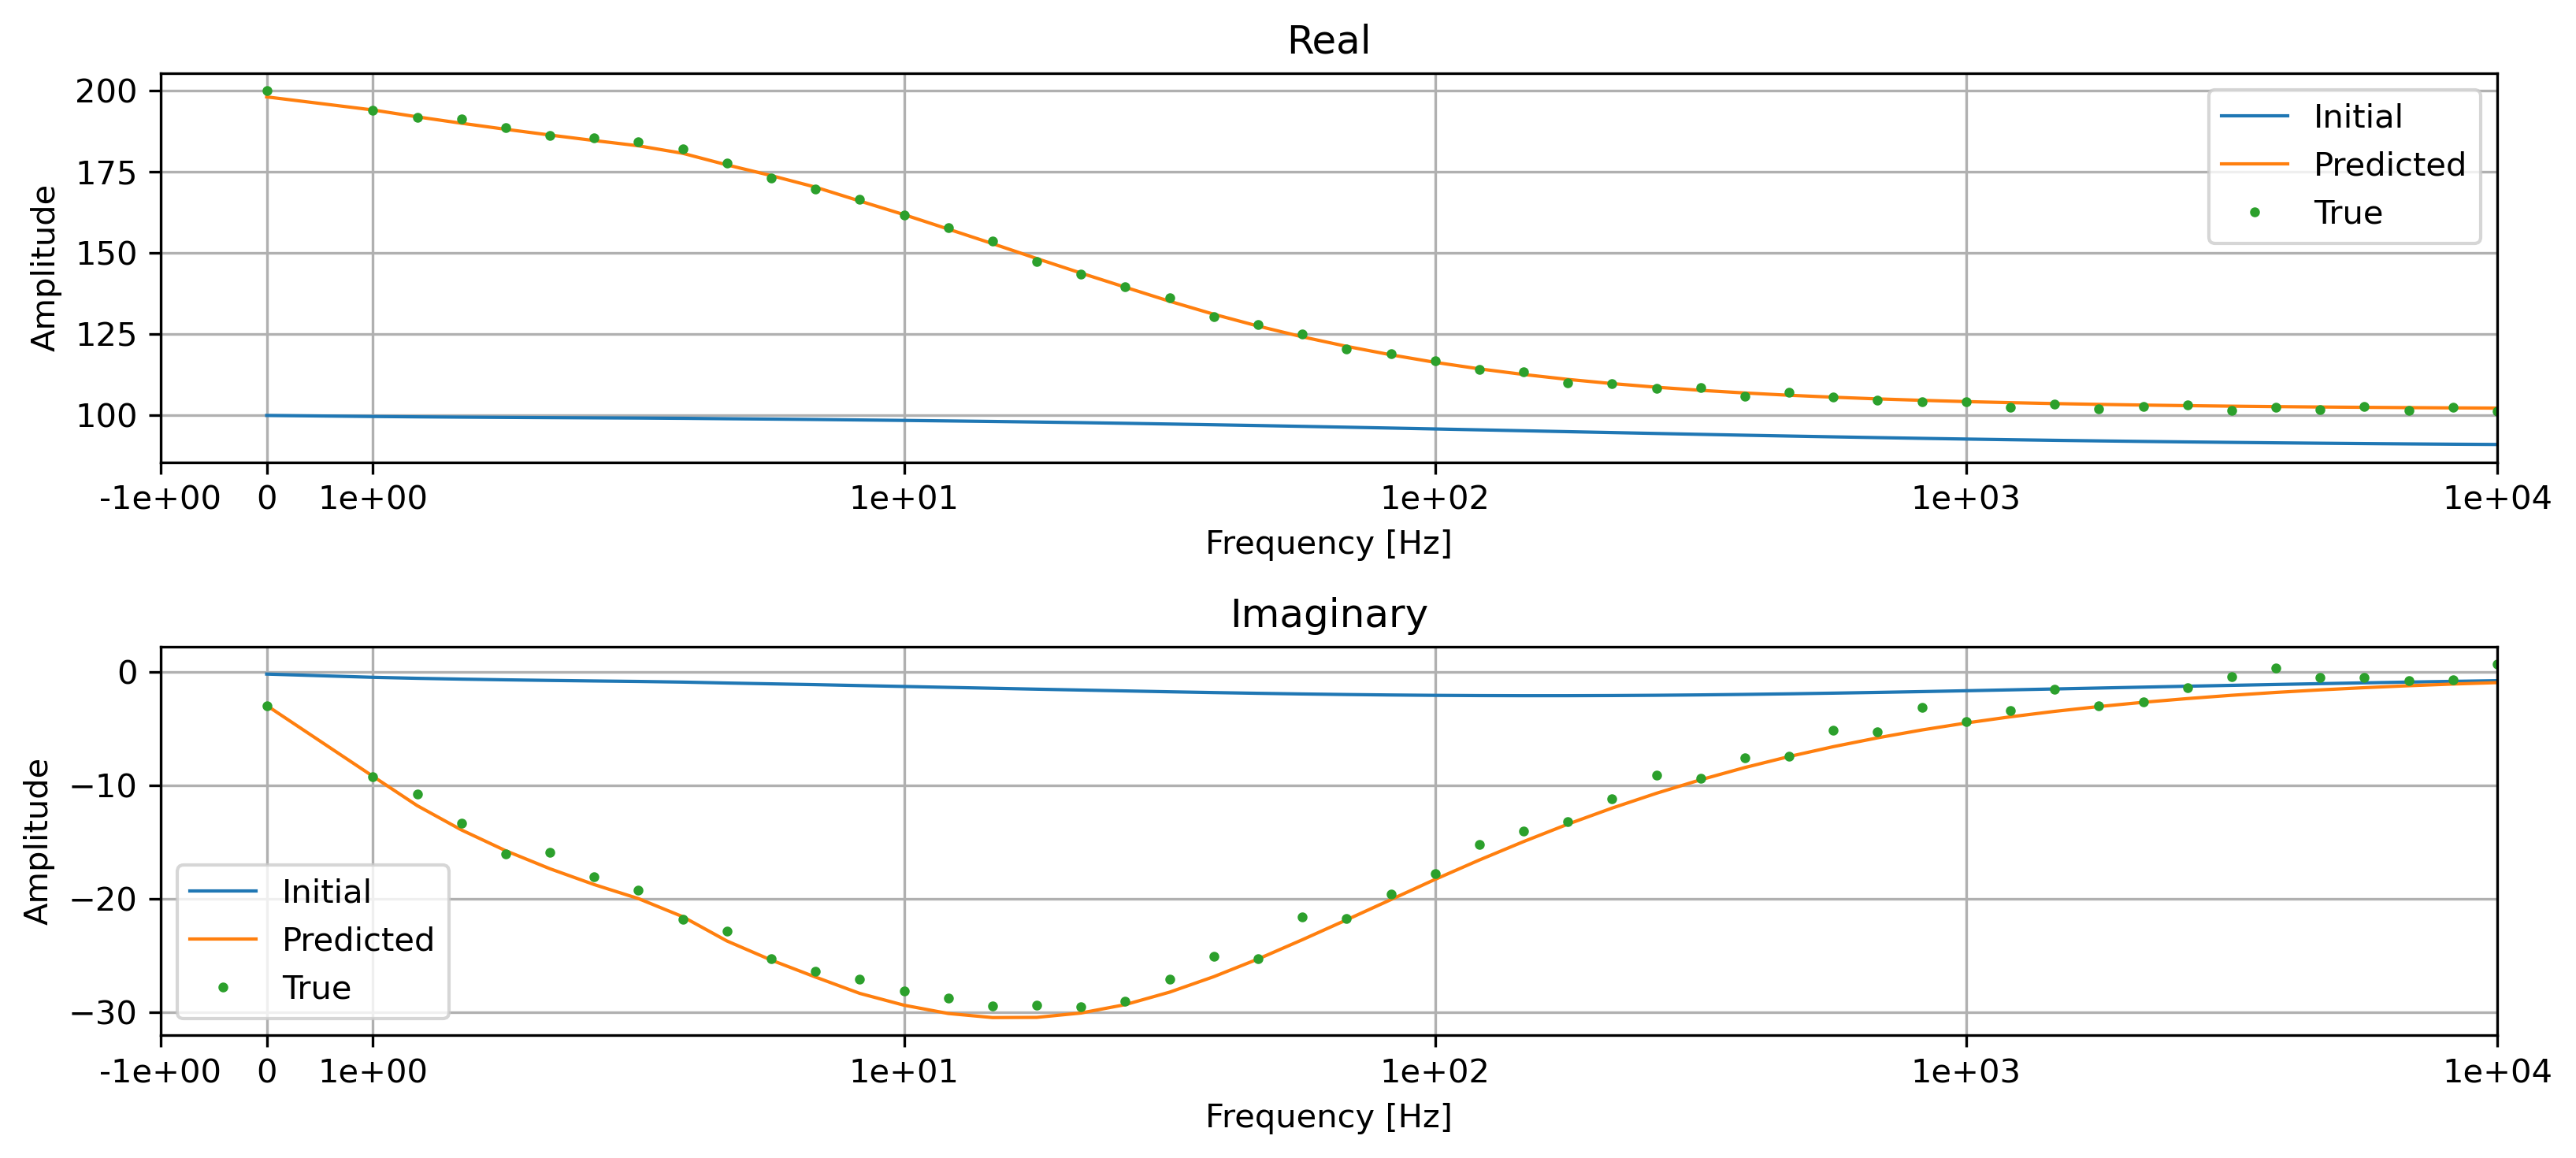

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dinit_real, ax=ax[0], yscale_log=False,
                          color = "C0",label="Initial")
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dest_real, ax=ax[0], yscale_log=False,
                            color = "C1",label="Predicted")
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dobs_real, ax=ax[0], yscale_log=False,
                 color = "C2",linestyle="",markersize=4.0, marker=".",label="True")
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_pelton.semiplx(x=windows_plot, y=dinit_imag, ax=ax[1], yscale_log=False,
                                color = "C0",label="Initial")
ax[1] = PL_pelton.semiplx(x=windows_plot, y=dest_imag, ax=ax[1], yscale_log=False,
                                color = "C1",label="Predicted")
ax[1] = PL_pelton.semiplx(x=windows_plot, y=dobs_imag, ax=ax[1], yscale_log=False,
                 color = "C2",linestyle="",markersize=4.0, marker=".",label="True")
PL_pelton.pl_axes_x(ax=ax[1])
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()

In [22]:
jacobian = compute_jacobian(mpred)
j_plot_real = jacobian[:nwindow].detach().numpy()
j_plot_imag = jacobian[nwindow:].detach().numpy()
print(j_plot_imag.shape)
print(j_plot_real.shape)

(50, 4)
(50, 4)


In [23]:
PL_jac = PsuedoLog(
            logmin=1e-7,
            linScale=0.2,
            logminx=10.**np.floor(np.log10(windows_plot[windows_plot>eps].min())),
            linScalex=0.2)

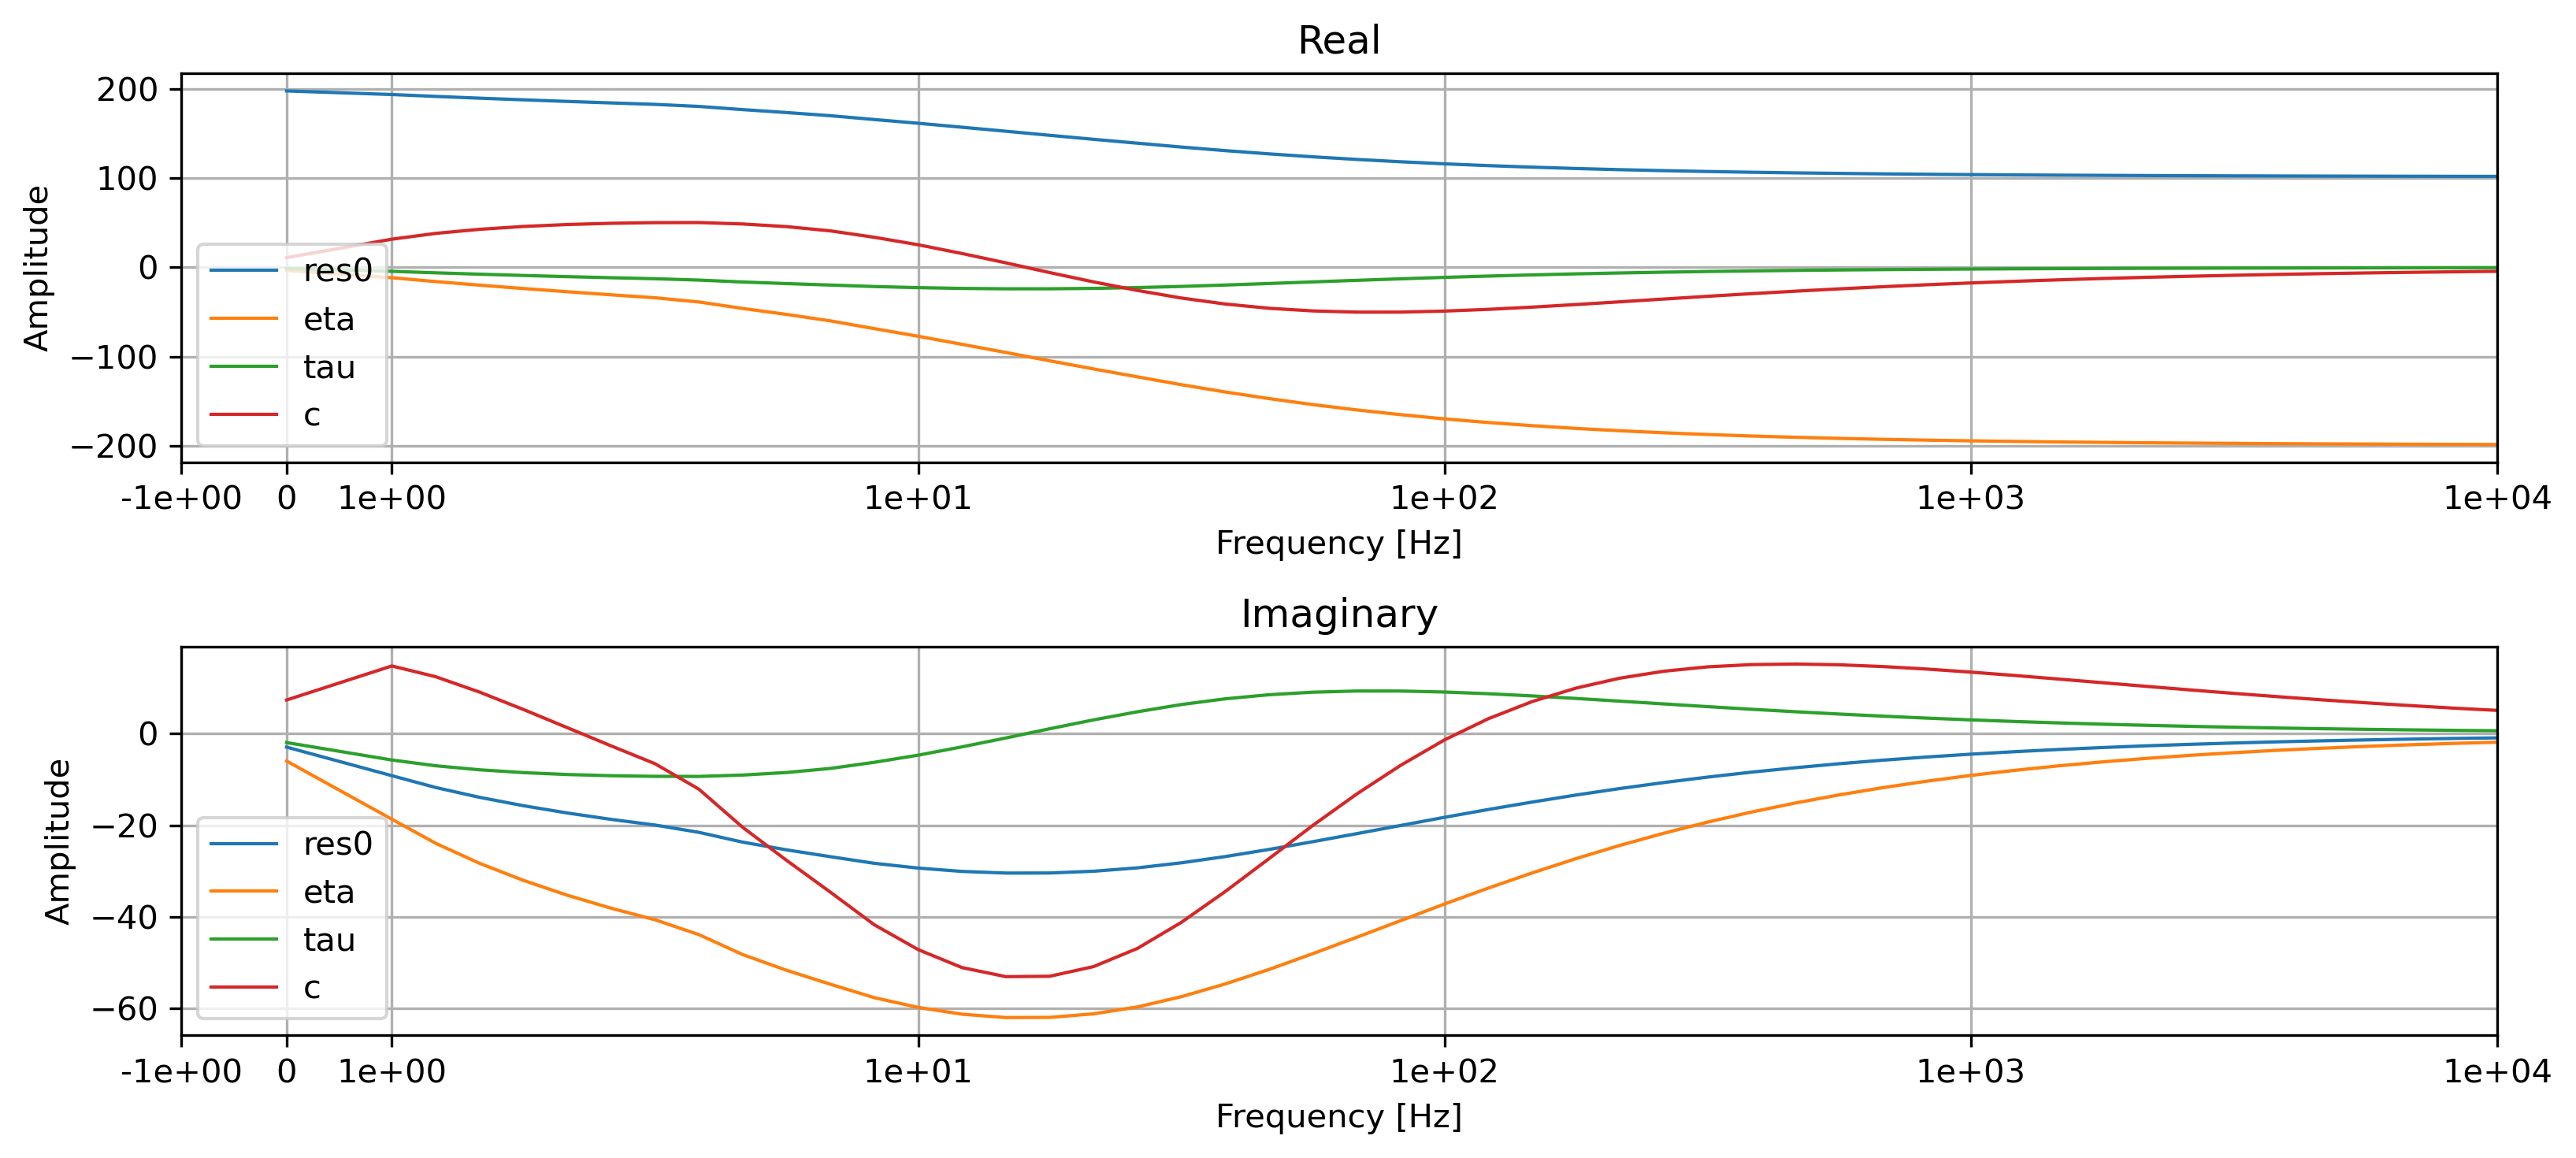

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0] = PL_jac.semiplx(x=windows_plot, y=j_plot_real[:,0], ax=ax[0], yscale_log=False,
                       color = "C0",label="res0")
ax[0] = PL_jac.semiplx(x=windows_plot, y=j_plot_real[:,1], ax=ax[0], yscale_log=False,
                          color = "C1",label="eta")
ax[0] = PL_jac.semiplx(x=windows_plot, y=j_plot_real[:,2], ax=ax[0], yscale_log=False,
                                color = "C2",label="tau")
ax[0] = PL_jac.semiplx(x=windows_plot, y=j_plot_real[:,3], ax=ax[0], yscale_log=False,
                                color = "C3",label="c")
PL_jac.pl_axes_x(ax=ax[0])
ax[1] = PL_jac.semiplx(x=windows_plot, y=j_plot_imag[:,0], ax=ax[1], yscale_log=False,
                          color = "C0",label="res0")
ax[1] = PL_jac.semiplx(x=windows_plot, y=j_plot_imag[:,1], ax=ax[1], yscale_log=False,
                                color = "C1",label="eta")       
ax[1] = PL_jac.semiplx(x=windows_plot, y=j_plot_imag[:,2], ax=ax[1], yscale_log=False,
                                color = "C2",label="tau")
ax[1] = PL_jac.semiplx(x=windows_plot, y=j_plot_imag[:,3], ax=ax[1], yscale_log=False,
                                color = "C3",label="c")
PL_jac.pl_axes_x(ax=ax[1])
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend(['res0','eta','tau','c'])
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dinit_real, ax=ax[0], yscale_log=False,
                          color = "C0",label="Initial")
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dest_real, ax=ax[0], yscale_log=False,
                            color = "C1",label="Predicted")
ax[0] = PL_pelton.semiplx(x=windows_plot, y=dobs_real, ax=ax[0], yscale_log=False,
                 color = "C2",linestyle="",markersize=4.0, marker=".",label="True")
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_pelton.semiplx(x=windows_plot, y=dinit_imag, ax=ax[1], yscale_log=False,
                                color = "C0",label="Initial")
ax[1] = PL_pelton.semiplx(x=windows_plot, y=dest_imag, ax=ax[1], yscale_log=False,
                                color = "C1",label="Predicted")
ax[1] = PL_pelton.semiplx(x=windows_plot, y=dobs_imag, ax=ax[1], yscale_log=False,
                 color = "C2",linestyle="",markersize=4.0, marker=".",label="True")
PL_pelton.pl_axes_x(ax=ax[1])
for a in ax:
#         a = PL_pelton.pl_axvline(ax=a, x=1/tau,color="C3",label=r'$1/\tau$')
# #        a = PL_pelton.pl_axvline(ax=a, x=1/tau/2/np.pi,label=r'$1/\tau $')
        a.set_xlabel('Frequency [Hz]')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()

Text(0, 0.5, 'Phase [Degrees]')

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


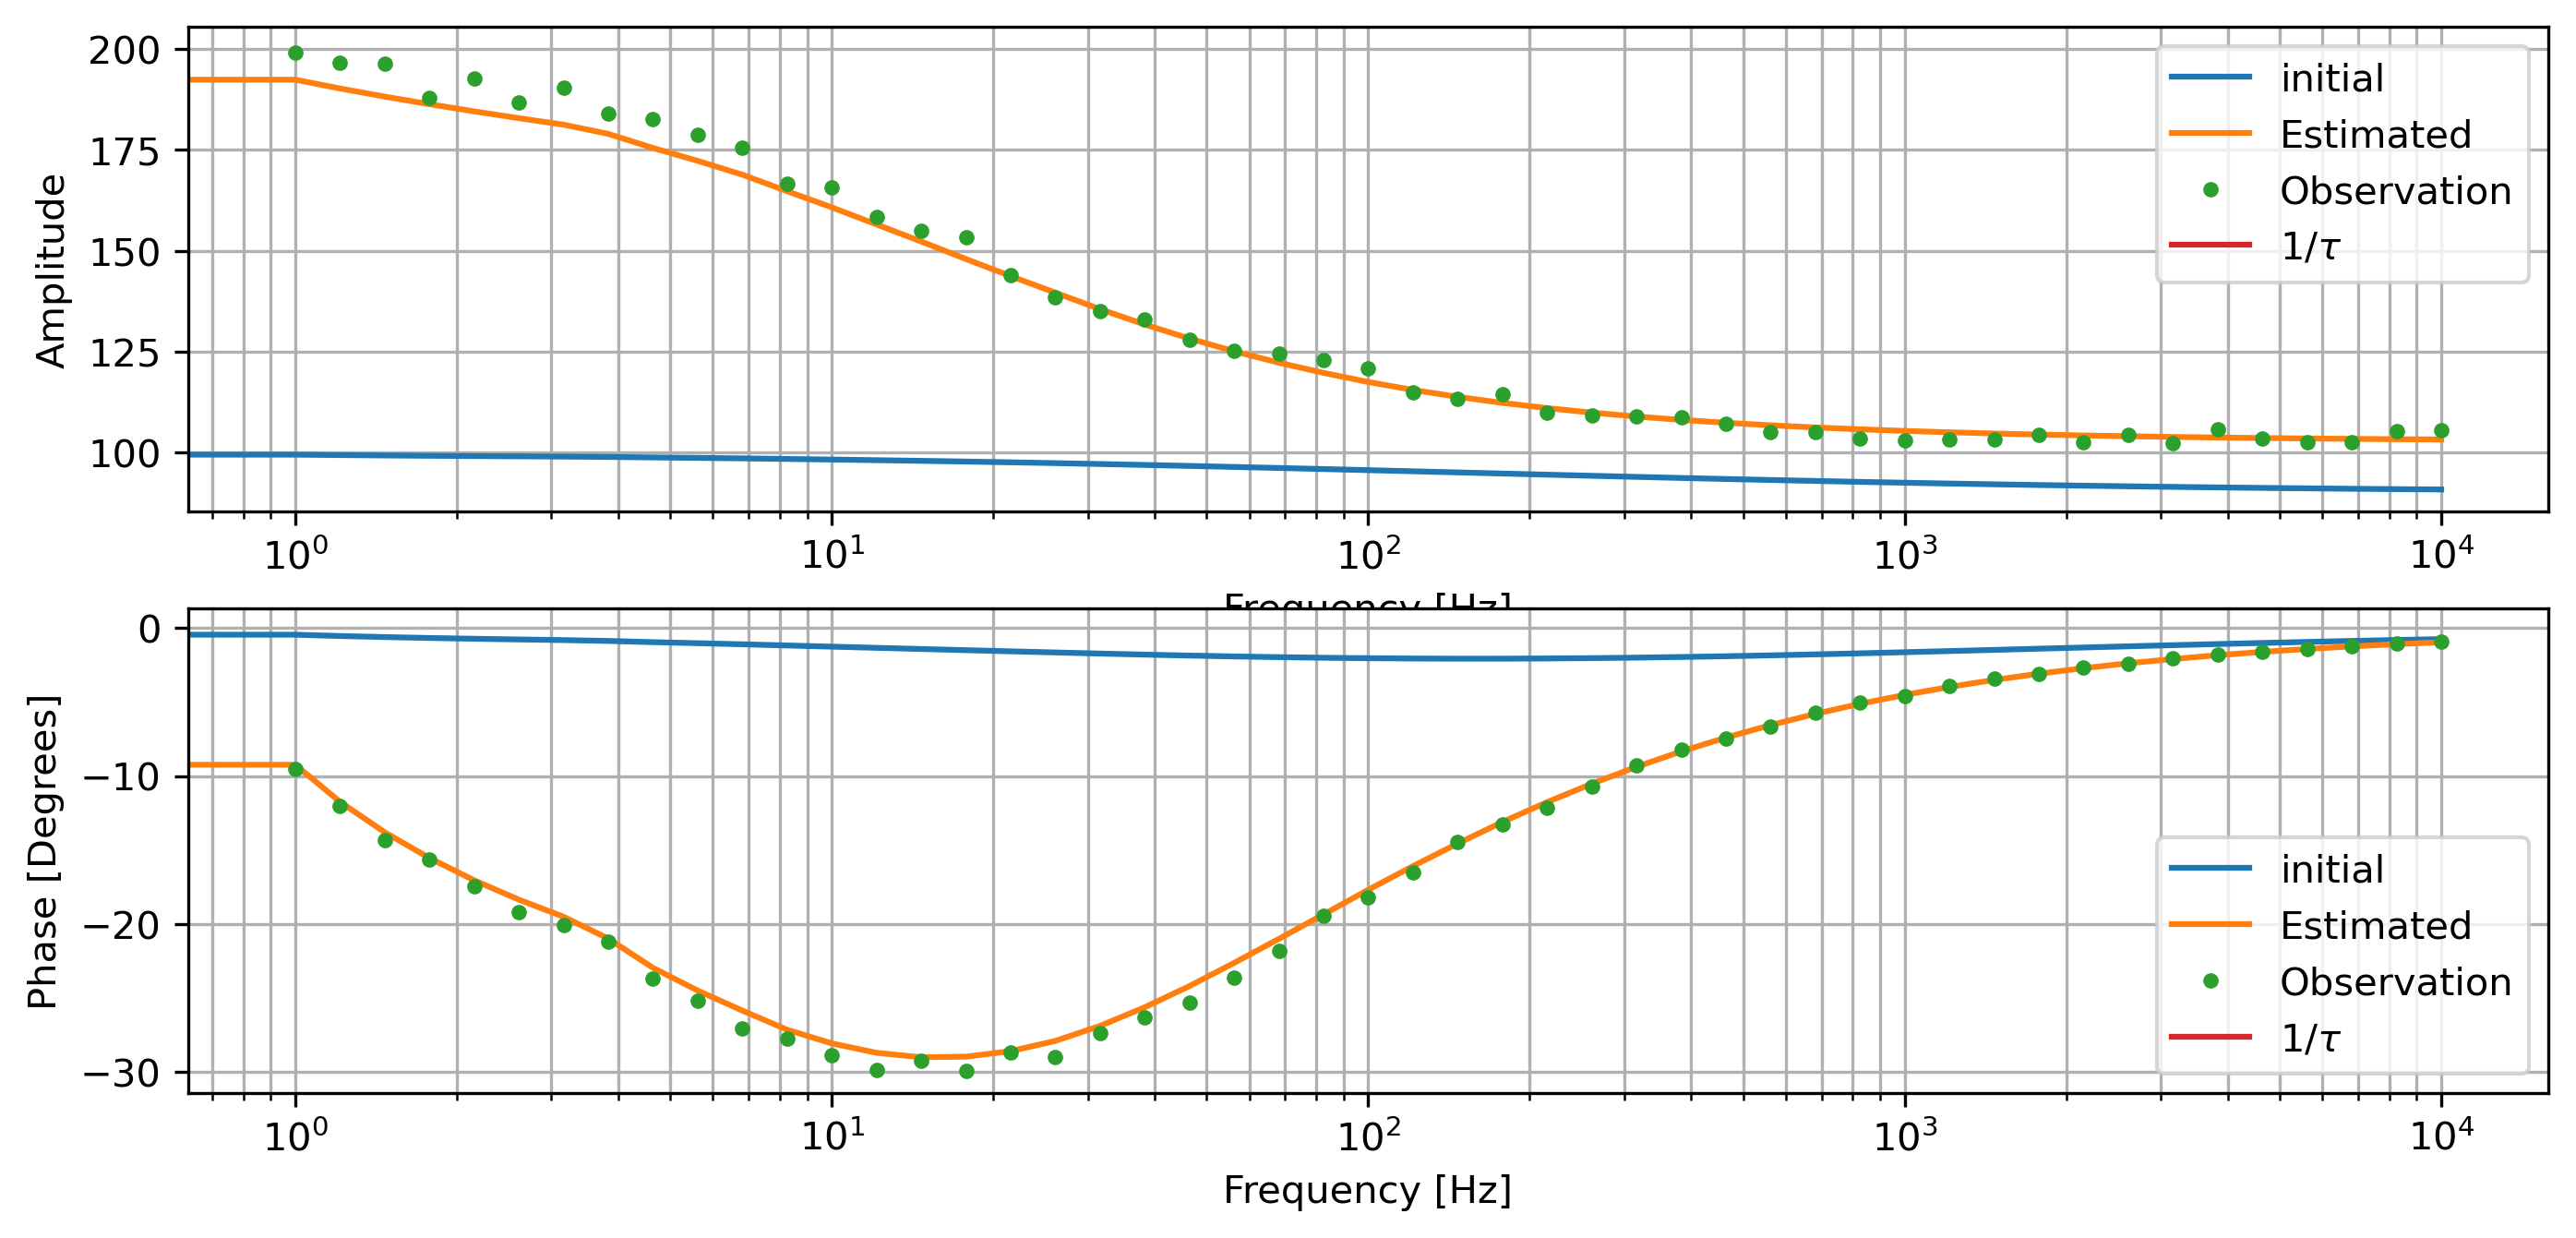

In [71]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0].semilogx(freq_window, dinit_real, label='initial', color="C0")
ax[0].semilogx(freq_window, dest_real, label='Estimated', color="C1")
ax[0].semilogx(freq_window, dobs_real, label='Observation', linestyle="",marker=".", color="C2")

ax[1].semilogx(freq_window, dinit_imag, label='initial', color="C0")
ax[1].semilogx(freq_window, dest_imag,  label='Estimated',  color="C1")
ax[1].semilogx(freq_window, dobs_imag,  label='Observation', linestyle="",marker=".",color="C2")

# Shared x-axis label and vertical line
tau = parm_true[2].detach().numpy()
for a in ax:
    a.axvline(x=1/tau ,color="C3",label=r'$1/\tau$')
    #        a = PL_pelton.pl_axvline(ax=a, x=1/tau/2/np.pi,label=r'$1/\tau $')
    a.set_xlabel('Frequency [Hz]')
    a.set_ylabel('Amplitude')
    a.grid(which='both')
    a.legend()
ax[1].set_ylabel('Phase [Degrees]')


Text(0, 0.5, 'Phase [Degrees]')

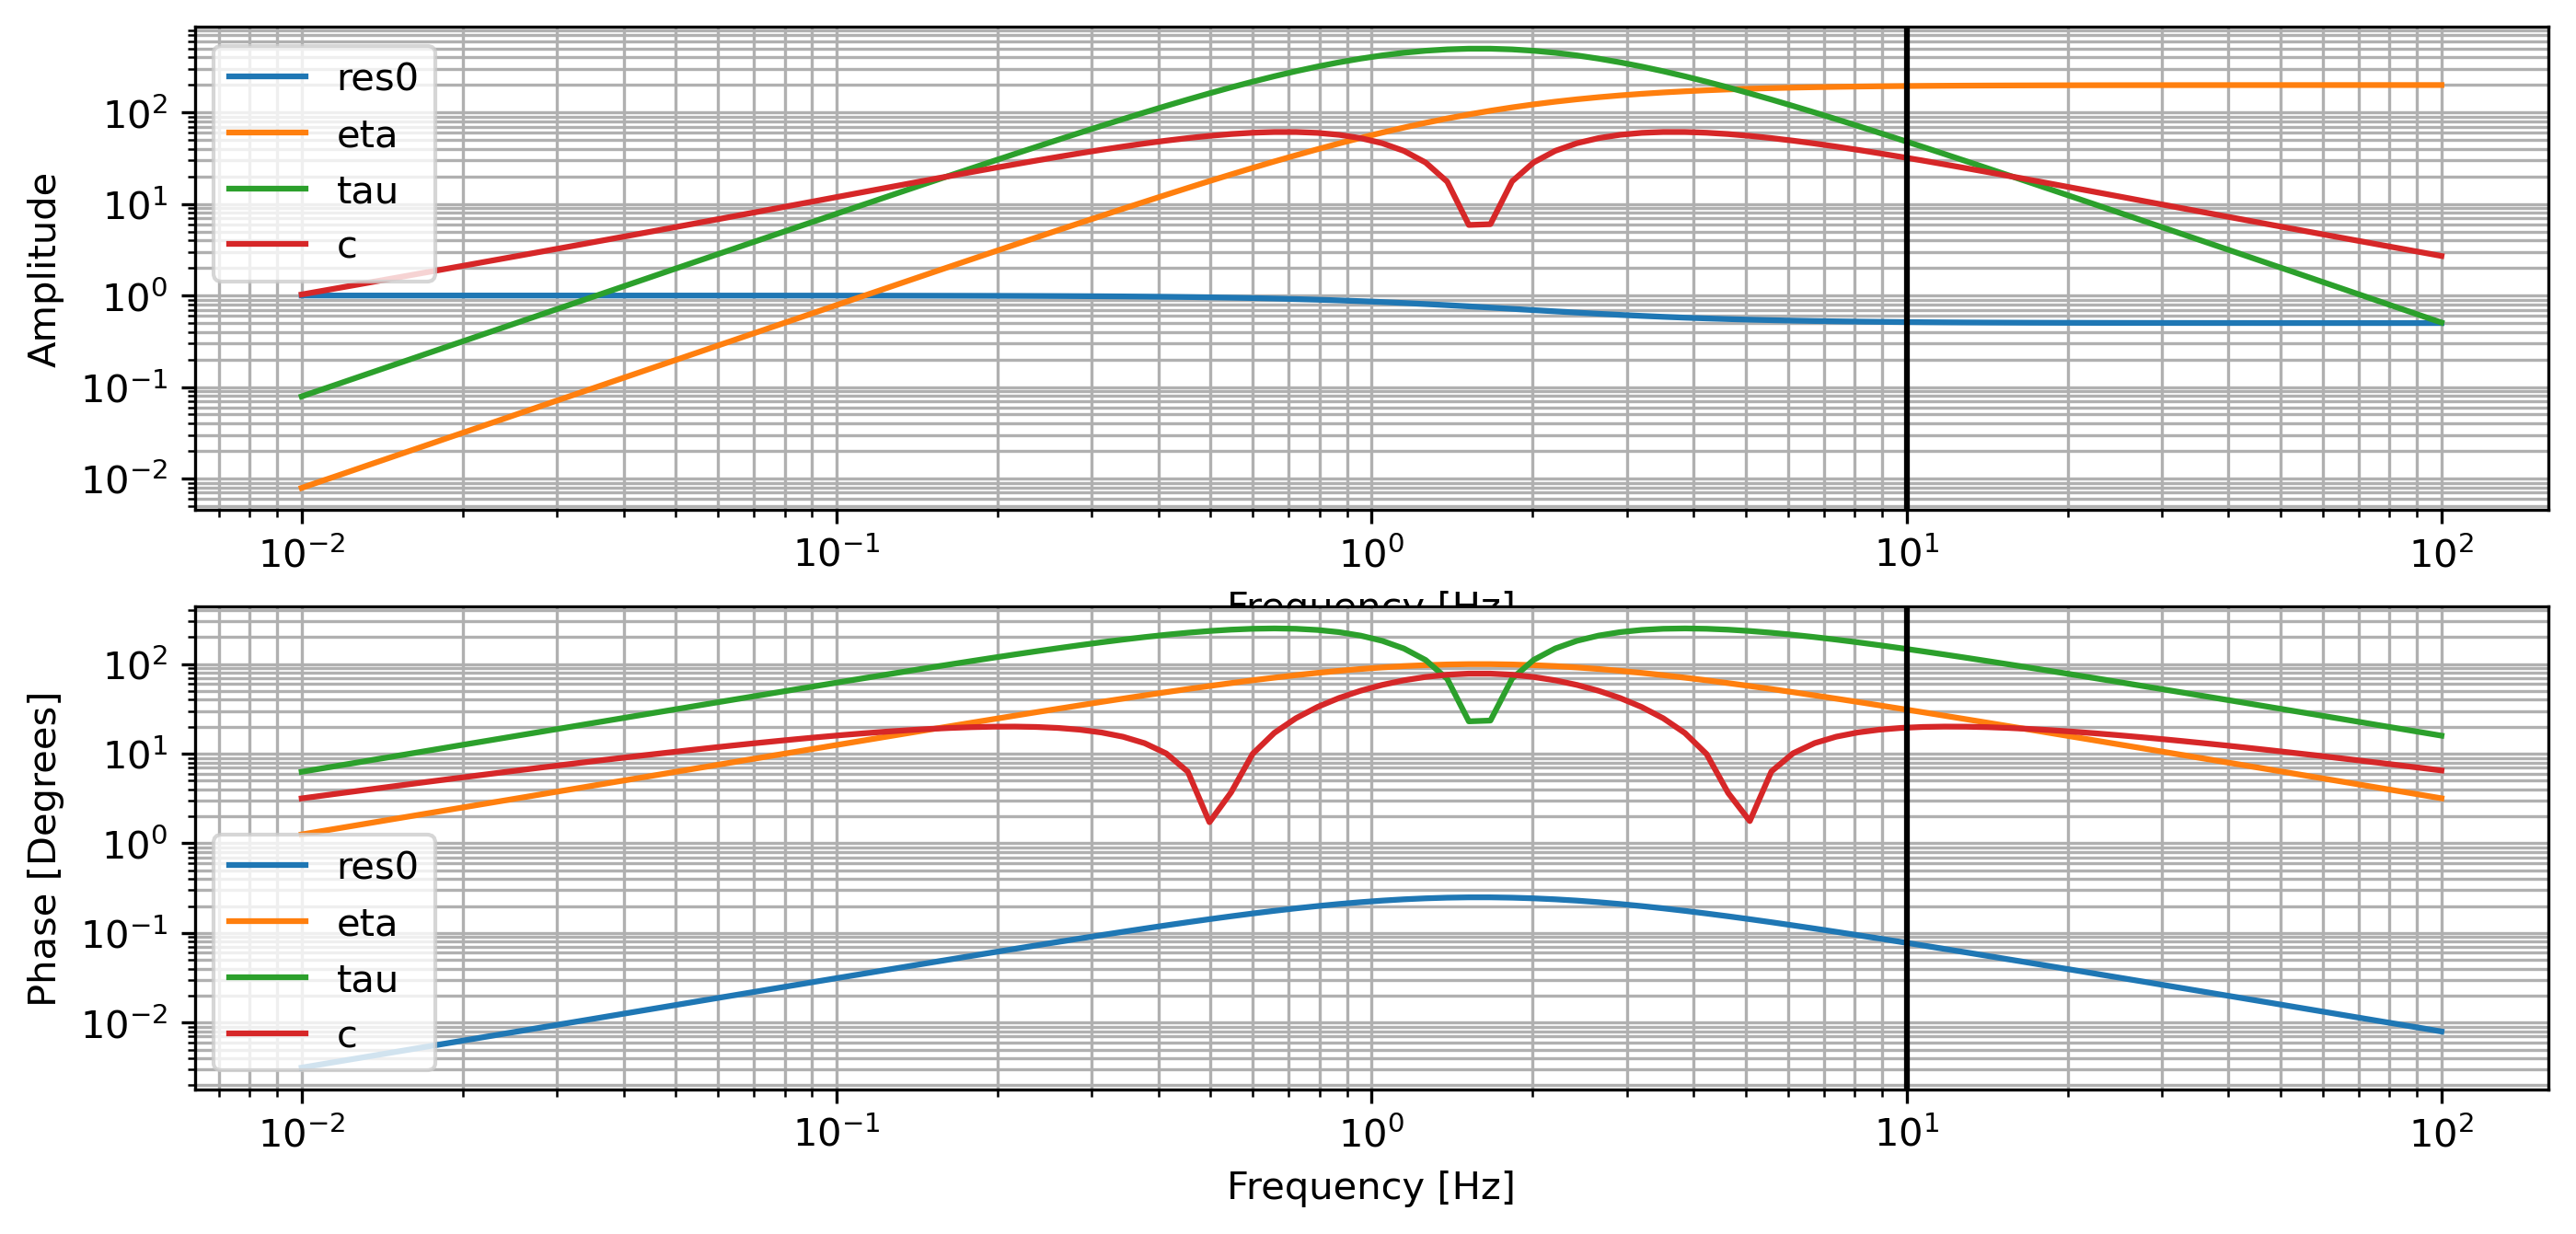

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0].loglog(freq, abs(grad_real))
# ax[0].loglog(freq, -grad_real, linestyle='--')  
ax[1].loglog(freq, abs(grad_imag))
# ax[1].loglog(freq, -grad_imag, linestyle='--')

# Shared x-axis label and vertical line
tau = parm_true[2].detach().numpy()
for a in ax:
    a.axvline(x=1/tau ,color="k",label=r'$1/\tau$')
    #        a = PL_pelton.pl_axvline(ax=a, x=1/tau/2/np.pi,label=r'$1/\tau $')
    a.set_xlabel('Frequency [Hz]')
    a.set_ylabel('Amplitude')
    a.grid(which='both')
    a.legend(['res0','eta','tau','c'])
ax[1].set_ylabel('Phase [Degrees]')


In [72]:

def Newton(mvec_init, niter, 
    s0=torch.tensor(1.0), sfac = torch.tensor(0.5), 
    stol=torch.tensor(1e-6), gtol=torch.tensor(1e-3), mu=torch.tensor(1e-4)):

    # mvec_old = mvec_init
    mvec_old = mvec_init.clone().detach()
    f_old = loss_fn(mvec_old).clone().detach()

    error_prg = torch.zeros(niter + 1)
    mvec_prg = torch.zeros((niter + 1, mvec_init.shape[0]))
    error_prg[0] = f_old
    mvec_prg[0, :] = mvec_old.detach()

    for i in range(niter):
        g = compute_gradient(mvec_old)
        h = compute_hessian(mvec_old)
        dm = torch.linalg.solve(h, g).flatten()  # Ensure dm is a 1D tensor
        g_norm = torch.linalg.norm(g, ord=2)

        if g_norm < gtol:
            print(f"Inversion complete since norm of gradient is small as: {g_norm:.3e}")
            break

        s = s0
#        mvec_new = mvec_old - s * dm
        mvec_new = clip_model(mvec_old - s * dm)
        f_new = loss_fn(mvec_new).clone().detach()
        directional_derivative = torch.dot(g.flatten(), -dm.flatten())
        while f_new >= f_old + s * mu * directional_derivative:
            s *= sfac
            # mvec_new = mvec_old - s * dm
            mvec_new = clip_model(mvec_old - s * dm)
            f_new = loss_fn(mvec_new).clone().detach()
            if s < stol:
                break
        mvec_old = mvec_new.clone().detach()
        mvec_prg[i + 1, :] = mvec_new.detach()
        f_old = f_new
        error_prg[i + 1] = f_new
        print(f'{i + 1:3}, step:{s:.1e}, gradient:{g_norm:.1e},  f:{f_new:.1e}')

    error_prg = error_prg[:i + 2]
    mvec_prg = mvec_prg[:i + 2]
    return mvec_new.detach(), mvec_prg
# mpred = ipmodel.GaussNewton(dobs=dobs, mvec_init=parm_init,niter=20)


# Gradient of objective function

In [74]:
# loss= loss_fn(parm_init)
# loss.backward()
# parm = parm_init.clone().detach().requires_grad_(True)
dest= dpred(parm)
r=  dest-dobs
# loss= 0.5 * torch.dot(r,r)
# loss.backward()

gradient_torch = compute_gradient(parm)
print(f"AD, Pytorch: {gradient_torch}")
#print(f"AD, Pytorch: {parm.grad}")
J_ana = pelton_res_f_grad(parm)
# print(f"Analyrtical: {(J_ana.T@(r)).flatten()}")
print(f"Analyrtical: {(J_ana.T@Wd.T@Wd@(r)).flatten()}")

AD, Pytorch: tensor([-260.3278, -356.9438,   -3.3511,  -36.4734])
Analyrtical: tensor([-260.3278, -356.9439,   -3.3511,  -36.4733], grad_fn=<MvBackward0>)


# Hessian of objective function 

In [78]:

Heessian_torch = compute_hessian(parm)
print(f"AD, Pytorch: {Heessian_torch}")
#print(f"AD, Pytorch: {parm.grad}")
J_ana = pelton_res_f_grad(parm)
#print(f"Analyrtical: {(J_ana.T@(J_ana))}")
print(f"Analyrtical: {(J_ana.T@Wd.T@Wd@(J_ana))}")

AD, Pytorch: tensor([[ 240.1814, -479.9484,   -8.5816,       nan],
        [-479.9484,  776.7286,  -35.2833,       nan],
        [  -8.5816,  -35.2834,    2.2154,       nan],
        [ -23.7072, -267.5242,   -6.4184,       nan]])
Analyrtical: tensor([[ 5.0051e+02, -1.2300e+02, -5.2305e+00,  1.2766e+01],
        [-1.2300e+02,  7.7673e+02, -1.7721e+00,  9.7209e+01],
        [-5.2305e+00, -1.7721e+00,  3.3461e-01, -1.3416e+00],
        [ 1.2766e+01,  9.7209e+01, -1.3416e+00,  2.3100e+01]],
       grad_fn=<MmBackward0>)


In [43]:
print(parm)
print(torch.isnan(parm), torch.isinf(parm))

tensor([ 4.6052,  0.1000, -4.6052,  0.5000], requires_grad=True)
tensor([False, False, False, False]) tensor([False, False, False, False])


# Model change 

In [127]:
parm_true = torch.tensor([np.log(200), 0.5, np.log(0.1), 0.6], dtype=torch.float32, requires_grad=False)
#parm_init = torch.tensor([100., 0.1, 0.1, 1.0], dtype=torch.float32, requires_grad=True)
parm_init = torch.tensor([np.log(100), 0.5, np.log(0.01), 0.7], dtype=torch.float32, requires_grad=True)
dest = dpred(parm_init)
dobs = dpred(parm_true)


In [128]:
dm = torch.linalg.solve(Heessian_torch, gradient_torch).flatten()
print(dm)

tensor([ -1.8040,   0.2554, -14.8618,  -0.2132])


In [129]:
alpha = gradient_torch.T @ gradient_torch/(gradient_torch.T @ Heessian_torch @ gradient_torch)
print(alpha)
print(alpha*gradient_torch)

tensor(2.4248e-05)
tensor([-1.6146,  0.1258,  0.0056, -0.0471])


C:\Users\81805\AppData\Local\Temp\ipykernel_7256\1965941473.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3641.)
  alpha = gradient_torch.T @ gradient_torch/(gradient_torch.T @ Heessian_torch @ gradient_torch)


# Newton method?

In [130]:
Wd = get_Wd(dobs, ratio=0.10, plateau=0)
print(Wd)

tensor([[0.0500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0507, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0514, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0526, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0551, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.000

In [33]:
niter = 10
s0=torch.tensor(1.0)
sfac = torch.tensor(0.5) 
stol=torch.tensor(1e-6)
gtol=torch.tensor(1e-3)
mu=torch.tensor(0.01)

#mvec_init = parm_init
# mvec_old = parm_init
mvec_old = parm_init.clone().detach().requires_grad_(True)
f_old = loss_fn(mvec_old)

for i in range(niter):
    g = compute_gradient(mvec_old)
    h = compute_hessian(mvec_old)
    dm = torch.linalg.solve(h, g)
    g_norm = torch.linalg.norm(g, ord=2)

    if g_norm < gtol:
        print(f"Inversion complete since norm of gradient is small as: {g_norm:.3e}")
        break
    s = s0
#    mvec_new = mvec_old - s * dm  
    mvec_new = clip_model(mvec_old - s * dm )
    f_new = loss_fn(mvec_new).clone().detach()
    directional_derivative = torch.dot(g.flatten(), -dm.flatten())
    while f_new >= f_old + s * mu * directional_derivative:
        s *= sfac
    #    mvec_new = mvec_old - s * dm  
        mvec_new = clip_model(mvec_old - s * dm )
        f_new = loss_fn(mvec_new).clone().detach()
        if s < stol:
            break
    mvec_old = mvec_new
    f_old = f_new
    print(f'{i + 1:3}, step:{s:.1e}, gradient:{g_norm:.1e},  f:{f_new:.1e}')
mpred= mvec_new.clone().detach()


  1, step:1.0e+00, gradient:6.7e+04,  f:nan
  2, step:1.0e+00, gradient:nan,  f:nan
  3, step:1.0e+00, gradient:nan,  f:nan
  4, step:1.0e+00, gradient:nan,  f:nan
  5, step:1.0e+00, gradient:nan,  f:nan
  6, step:1.0e+00, gradient:nan,  f:nan
  7, step:1.0e+00, gradient:nan,  f:nan
  8, step:1.0e+00, gradient:nan,  f:nan
  9, step:1.0e+00, gradient:nan,  f:nan
 10, step:1.0e+00, gradient:nan,  f:nan


In [132]:
dest = dpred(mpred)
dinit = dpred(parm_init)

print(f"initial  :{parm_init}")
print(f"predicted:{mpred}")
print(f"true     :{parm_true}")


initial  :tensor([ 4.6052,  0.5000, -4.6052,  0.7000], requires_grad=True)
predicted:tensor([ 5.2568,  0.8676, -5.4600,  0.4000])
true     :tensor([ 5.2983,  0.5000, -2.3026,  0.6000])


# Gradient Descent?

In [19]:
niter = 100
s0=torch.tensor(1.0)
sfac = torch.tensor(0.5) 
stol=torch.tensor(1e-6)
gtol=torch.tensor(1e-3)
mu=torch.tensor(0.01)

#mvec_init = parm_init
# mvec_old = parm_init
mvec_old = parm_init.clone().detach()
f_old = loss_fn(mvec_old).clone().detach()

for i in range(niter):
    g = compute_gradient(mvec_old)
    h = compute_hessian(mvec_old)
    alpha = g.T @ g / (g.T @ h @ g)
    # alpha=1.e-4
    dm  = g * alpha
    g_norm = torch.linalg.norm(g, ord=2)
    if g_norm < gtol:
        print(f"Inversion complete since norm of gradient is small as: {g_norm:.3e}")
        break
    s = s0
#    mvec_new = mvec_old - s * dm  
    mvec_new = clip_model(mvec_old - s * dm )
    f_new = loss_fn(mvec_new).clone().detach()
    directional_derivative = torch.dot(g.flatten(), -dm.flatten())
    while f_new >= f_old + s * mu * directional_derivative:
        s *= sfac
    #    mvec_new = mvec_old - s * dm  
        mvec_new = clip_model(mvec_old - s * dm )
        f_new = loss_fn(mvec_new).clone().detach()
        if s < stol:
            break
    mvec_old = mvec_new
    f_old = f_new
    print(f'{i + 1:3}, step:{s:.1e}, gradient:{g_norm:.1e},  f:{f_new:.1e}')
mpred= mvec_new.clone().detach()


C:\Users\81805\AppData\Local\Temp\ipykernel_23928\1574369576.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3641.)
  alpha = g.T @ g / (g.T @ h @ g)


  1, step:1.0e+00, gradient:6.7e+04,  f:nan
  2, step:1.0e+00, gradient:nan,  f:nan
  3, step:1.0e+00, gradient:nan,  f:nan
  4, step:1.0e+00, gradient:nan,  f:nan
  5, step:1.0e+00, gradient:nan,  f:nan
  6, step:1.0e+00, gradient:nan,  f:nan
  7, step:1.0e+00, gradient:nan,  f:nan
  8, step:1.0e+00, gradient:nan,  f:nan
  9, step:1.0e+00, gradient:nan,  f:nan
 10, step:1.0e+00, gradient:nan,  f:nan
 11, step:1.0e+00, gradient:nan,  f:nan
 12, step:1.0e+00, gradient:nan,  f:nan
 13, step:1.0e+00, gradient:nan,  f:nan
 14, step:1.0e+00, gradient:nan,  f:nan
 15, step:1.0e+00, gradient:nan,  f:nan
 16, step:1.0e+00, gradient:nan,  f:nan
 17, step:1.0e+00, gradient:nan,  f:nan
 18, step:1.0e+00, gradient:nan,  f:nan
 19, step:1.0e+00, gradient:nan,  f:nan
 20, step:1.0e+00, gradient:nan,  f:nan
 21, step:1.0e+00, gradient:nan,  f:nan
 22, step:1.0e+00, gradient:nan,  f:nan
 23, step:1.0e+00, gradient:nan,  f:nan
 24, step:1.0e+00, gradient:nan,  f:nan
 25, step:1.0e+00, gradient:nan,  f:

In [20]:
dest = dpred(mpred)
dinit = dpred(parm_init)

print(f"initial  :{parm_init}")
print(f"predicted:{mpred}")
print(f"true     :{parm_true}")


initial  :tensor([ 4.6052,  0.1000, -4.6052,  0.5000], requires_grad=True)
predicted:tensor([nan, nan, nan, nan])
true     :tensor([ 5.2983,  0.5000, -2.3026,  0.7000])


# Gauss Newton

  1, step:1.0e+00, gradient:6.7e+04,  f:1.0e+04
  2, step:1.0e+00, gradient:9.2e+04,  f:1.4e+02
  3, step:1.0e+00, gradient:3.2e+03,  f:1.9e+01
  4, step:1.0e+00, gradient:2.0e+03,  f:3.2e-03
  5, step:1.0e+00, gradient:2.1e+01,  f:2.5e-09
  6, step:1.0e+00, gradient:3.1e-02,  f:3.4e-10
  7, step:9.5e-07, gradient:6.9e-03,  f:3.4e-10
  8, step:4.8e-07, gradient:6.9e-03,  f:3.4e-10
  9, step:2.4e-07, gradient:6.9e-03,  f:3.4e-10
 10, step:1.2e-07, gradient:6.9e-03,  f:3.4e-10
 11, step:6.0e-08, gradient:6.9e-03,  f:3.4e-10
 12, step:3.0e-08, gradient:6.9e-03,  f:3.4e-10
 13, step:1.5e-08, gradient:6.9e-03,  f:3.4e-10


initial  :tensor([ 4.6052,  0.1000, -4.6052,  0.5000], requires_grad=True)
predicted:tensor([ 5.2983,  0.5000, -2.3026,  0.7000])
true     :tensor([ 5.2983,  0.5000, -2.3026,  0.7000])


tensor([[ 4.6052,  0.1000, -4.6052,  0.5000],
        [ 5.6542,  0.8036, -2.3026,  0.4000],
        [ 5.3389,  0.5562, -2.3026,  0.5308],
        [ 5.2916,  0.4865, -2.3026,  0.6851],
        [ 5.2983,  0.5000, -2.3026,  0.7006],
        [ 5.2983,  0.5000, -2.3026,  0.7000],
        [ 5.2983,  0.5000, -2.3026,  0.7000],
        [ 5.2983,  0.5000, -2.3026,  0.7000],
        [ 5.2983,  0.5000, -2.3026,  0.7000],
        [ 5.2983,  0.5000, -2.3026,  0.7000],
        [ 5.2983,  0.5000, -2.3026,  0.7000],
        [ 5.2983,  0.5000, -2.3026,  0.7000],
        [ 5.2983,  0.5000, -2.3026,  0.7000],
        [ 5.2983,  0.5000, -2.3026,  0.7000]], grad_fn=<SliceBackward0>)


In [24]:
Hessian = torch.autograd.functional.hessian(loss_fn, parm)
print(f"AD, Pytorch: {Hessian}")

AD, Pytorch: tensor([[ 3.8200e+04, -2.0121e+04, -5.0248e+02,         nan],
        [-2.0121e+04,  1.5186e+04,  2.6271e+03,         nan],
        [-5.0248e+02,  2.6271e+03,  9.5054e+01,         nan],
        [ 1.2329e+01, -1.8970e+04, -3.0963e+02,         nan]])


In [25]:
def loss_fn_test (x):
    return x[0]**2 + x[1]**2 + x[2]**2
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
Hessian = torch.autograd.functional.hessian(loss_fn, [x])

TypeError: The inputs given to hessian must be either a Tensor or a tuple of Tensors but the given inputs has type <class 'list'>.

In [15]:
print(dobs.shape)  # Check tensor shape
print(dest.shape)

# Fix using torch.dot with flattening
result = torch.dot(dobs, dest)
print(result)

# OR fix using torch.matmul if they are column vectors
result = torch.matmul(dobs.T, dest)
print(result)


torch.Size([200])
torch.Size([200])
tensor(1521936.5000, grad_fn=<DotBackward0>)
tensor(1521936.5000, grad_fn=<DotBackward0>)


In [16]:
parm = parm_init.clone().detach().requires_grad_(True)
dest = dpred(parm, freq)
J_ana = pelton_res_f_grad(parm, freq)
# r = dest-dobs
# loss = 0.5 * torch.dot(r.flatten(), r.flatten())
loss = loss_fn(dobs, parm = parm, dpred_fn=dpred, freq=freq)

print(loss)
loss.backward()
print(f"AD, Pytorch: {parm.grad}")
print(f"Analyrtical: {(J_ana.T@(dest-dobs)).flatten()}")
# hessian = torch.autograd.functional.hessian(loss_fn, parm, dpred, freq)
# print("Hessian of the Loss function:\n", hessian)
# print(f"Analyrtical: {(J_ana.T@J_ana).flatten()}")

tensor(278050.8125, grad_fn=<MulBackward0>)
AD, Pytorch: tensor([ -5717.8198,  37638.9375, 198445.2188, -22106.5605])
Analyrtical: tensor([ -5717.8174,  37638.9414, 198445.2031, -22106.5566],
       grad_fn=<MvBackward0>)


In [42]:
parm = parm_init.clone().detach().requires_grad_(True)
optimizer = torch.optim.SGD([parm], lr=0.1)

# Gradient Descent Loop
for i in range(100):
    optimizer.zero_grad()  # Clear previous gradients
    loss = loss_fn(parm=parm, dpred_fn=dpred,freq=freq, dobs=dobs)  # Compute loss
    loss.backward()  # Compute gradients
    optimizer.step()  # Update parameters

   # print(f"Iteration {i+1}: x = {parm.item():.4f}, Loss = {loss.item():.4f}")

#print(f"Optimal x: {param.item():.4f}")

In [43]:
parm

tensor([nan, nan, nan, nan], requires_grad=True)

In [32]:
# # Define frequency array using NumPy
# freq = np.linspace(1, 1000, 100)

# Initialize the InducedPolarization class
ipmodel = InducedPolarization(freq=freq)


In [33]:
dobs = ipmodel.dpred(parm_true)
print(dobs)

tensor([[199.9960],
        [199.9952],
        [199.9943],
        [199.9931],
        [199.9917],
        [199.9900],
        [199.9879],
        [199.9855],
        [199.9825],
        [199.9789],
        [199.9746],
        [199.9695],
        [199.9632],
        [199.9557],
        [199.9466],
        [199.9357],
        [199.9226],
        [199.9068],
        [199.8877],
        [199.8647],
        [199.8371],
        [199.8039],
        [199.7639],
        [199.7157],
        [199.6578],
        [199.5881],
        [199.5043],
        [199.4035],
        [199.2824],
        [199.1370],
        [198.9623],
        [198.7527],
        [198.5015],
        [198.2005],
        [197.8405],
        [197.4103],
        [196.8972],
        [196.2862],
        [195.5604],
        [194.7006],
        [193.6853],
        [192.4909],
        [191.0920],
        [189.4623],
        [187.5750],
        [185.4049],
        [182.9297],
        [180.1323],
        [177.0036],
        [173.5450],


In [34]:
#J_ana = ipmodel.pelton_res_f_grad(parm_init)
J_ana = ipmodel.pelton_res_f_grad(parm_true)
print(J_ana.shape)
print(J_ana)

torch.Size([200, 4])
tensor([[ 9.9998e-01, -7.8917e-03, -7.8951e-02,  1.0269e+00],
        [ 9.9998e-01, -9.5129e-03, -9.5095e-02,  1.1304e+00],
        [ 9.9997e-01, -1.1444e-02, -1.1454e-01,  1.2445e+00],
        [ 9.9997e-01, -1.3804e-02, -1.3796e-01,  1.3705e+00],
        [ 9.9996e-01, -1.6618e-02, -1.6617e-01,  1.5096e+00],
        [ 9.9995e-01, -2.0027e-02, -2.0014e-01,  1.6632e+00],
        [ 9.9994e-01, -2.4104e-02, -2.4106e-01,  1.8329e+00],
        [ 9.9993e-01, -2.9039e-02, -2.9035e-01,  2.0204e+00],
        [ 9.9991e-01, -3.4964e-02, -3.4971e-01,  2.2276e+00],
        [ 9.9989e-01, -4.2117e-02, -4.2119e-01,  2.4568e+00],
        [ 9.9987e-01, -5.0747e-02, -5.0728e-01,  2.7104e+00],
        [ 9.9985e-01, -6.1107e-02, -6.1096e-01,  2.9910e+00],
        [ 9.9982e-01, -7.3600e-02, -7.3581e-01,  3.3016e+00],
        [ 9.9978e-01, -8.8656e-02, -8.8616e-01,  3.6456e+00],
        [ 9.9973e-01, -1.0678e-01, -1.0672e+00,  4.0267e+00],
        [ 9.9968e-01, -1.2859e-01, -1.2851e+00,  

In [35]:
dpred = ipmodel.dpred(parm_init)
J_ana = ipmodel.pelton_res_f_grad(parm_init)
r = dpred-dobs
loss = 0.5 * torch.dot(r.flatten(), r.flatten())
print(loss)
loss.backward()
print(f"AD, Pytorch: {parm_init.grad}")
print(f"Analyrtical: {(J_ana.T@r).flatten()}")


tensor(278050.8125, grad_fn=<MulBackward0>)
AD, Pytorch: tensor([ -28589.0996,  188194.6875,  992226.1250, -110532.8047])
Analyrtical: tensor([ -5717.8174,  37638.9414, 198445.2031, -22106.5566],
       grad_fn=<ViewBackward0>)


In [30]:
mpred, mvec_prg = ipmodel.GaussNewton(dobs=dobs, mvec_init=parm_init,niter=10)

  1, step:5.0e-01, gradient:2.0e+04,  f:3.6e+03
  2, step:5.0e-01, gradient:8.9e+03,  f:7.3e+02
  3, step:5.0e-01, gradient:1.0e+04,  f:1.8e+02
  4, step:5.0e-01, gradient:4.5e+03,  f:4.5e+01
  5, step:5.0e-01, gradient:2.1e+03,  f:1.1e+01
  6, step:5.0e-01, gradient:1.0e+03,  f:2.8e+00
  7, step:5.0e-01, gradient:5.1e+02,  f:6.9e-01
  8, step:5.0e-01, gradient:2.5e+02,  f:1.7e-01
  9, step:5.0e-01, gradient:1.3e+02,  f:4.3e-02
 10, step:5.0e-01, gradient:6.2e+01,  f:1.1e-02


In [21]:
dpred = ipmodel.dpred(mpred)
dinit = ipmodel.dpred(parm_init)

print(f"predicted:{mpred}")
print(f"true     :{parm_true}")
print(f"initial  :{parm_init}")

predicted:tensor([1.9984e+02, 4.9972e-01, 1.0000e-01, 9.9933e-01])
true     :tensor([2.0000e+02, 5.0000e-01, 1.0000e-01, 1.0000e+00], requires_grad=True)
initial  :tensor([1.0000e+02, 1.0000e-01, 1.0000e-02, 5.0000e-01], requires_grad=True)


In [32]:
# Define Parameters
res0_default = torch.tensor(200., dtype=torch.float32, requires_grad=True)
eta_default = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
tau_default = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)
c_default = torch.tensor(1., dtype=torch.float32, requires_grad=True)

con8_default = 1 / (res0_default * (1 - eta_default))

# Define Parameters
res0_default = torch.tensor(200., dtype=torch.float32, requires_grad=True)
eta_default = torch.tensor(0.5, dtype=torch.float32, requires_grad=True)
tau_default = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)
c_default = torch.tensor(1., dtype=torch.float32, requires_grad=True)

con8_default = 1 / (res0_default * (1 - eta_default))

nfreq = torch.tensor(2**8, dtype=torch.float32)
freqcen = 1 / tau_default
freqend = freqcen * nfreq**0.5
freqstep = freqend / nfreq

# Convert to Scalars for torch.arange
freqend_scalar = freqend.item()
freqstep_scalar = freqstep.item()
freq = torch.arange(0, freqend_scalar, freqstep_scalar)

# Initialize Model
IPmodel_f = InducedPolarization(
    con8=con8_default,
    res0=res0_default,
    eta=eta_default,
    tau=tau_default,
    c=c_default
)



In [37]:
# Compute FFT Response
fft_f = IPmodel_f.pelton_res_f(freq, res0_default, eta_default, tau_default, c_default)
fft_f_real = fft_f.real
fft_f_imag = fft_f.imag

In [38]:
fft_f_real.sum().backward(retain_graph=True)  # Compute gradient for real part
fft_f_imag.sum().backward()  # Compute gradient for imaginary part
# Print Gradients
print("Gradient of res0:", res0_default.grad)
print("Gradient of eta:", eta_default.grad)
print("Gradient of tau:", tau_default.grad)
print("Gradient of c:", c_default.grad)

Gradient of res0: tensor(248.7723)
Gradient of eta: tensor(-105291.0781)
Gradient of tau: tensor(10549.2881)
Gradient of c: tensor(296.0344)


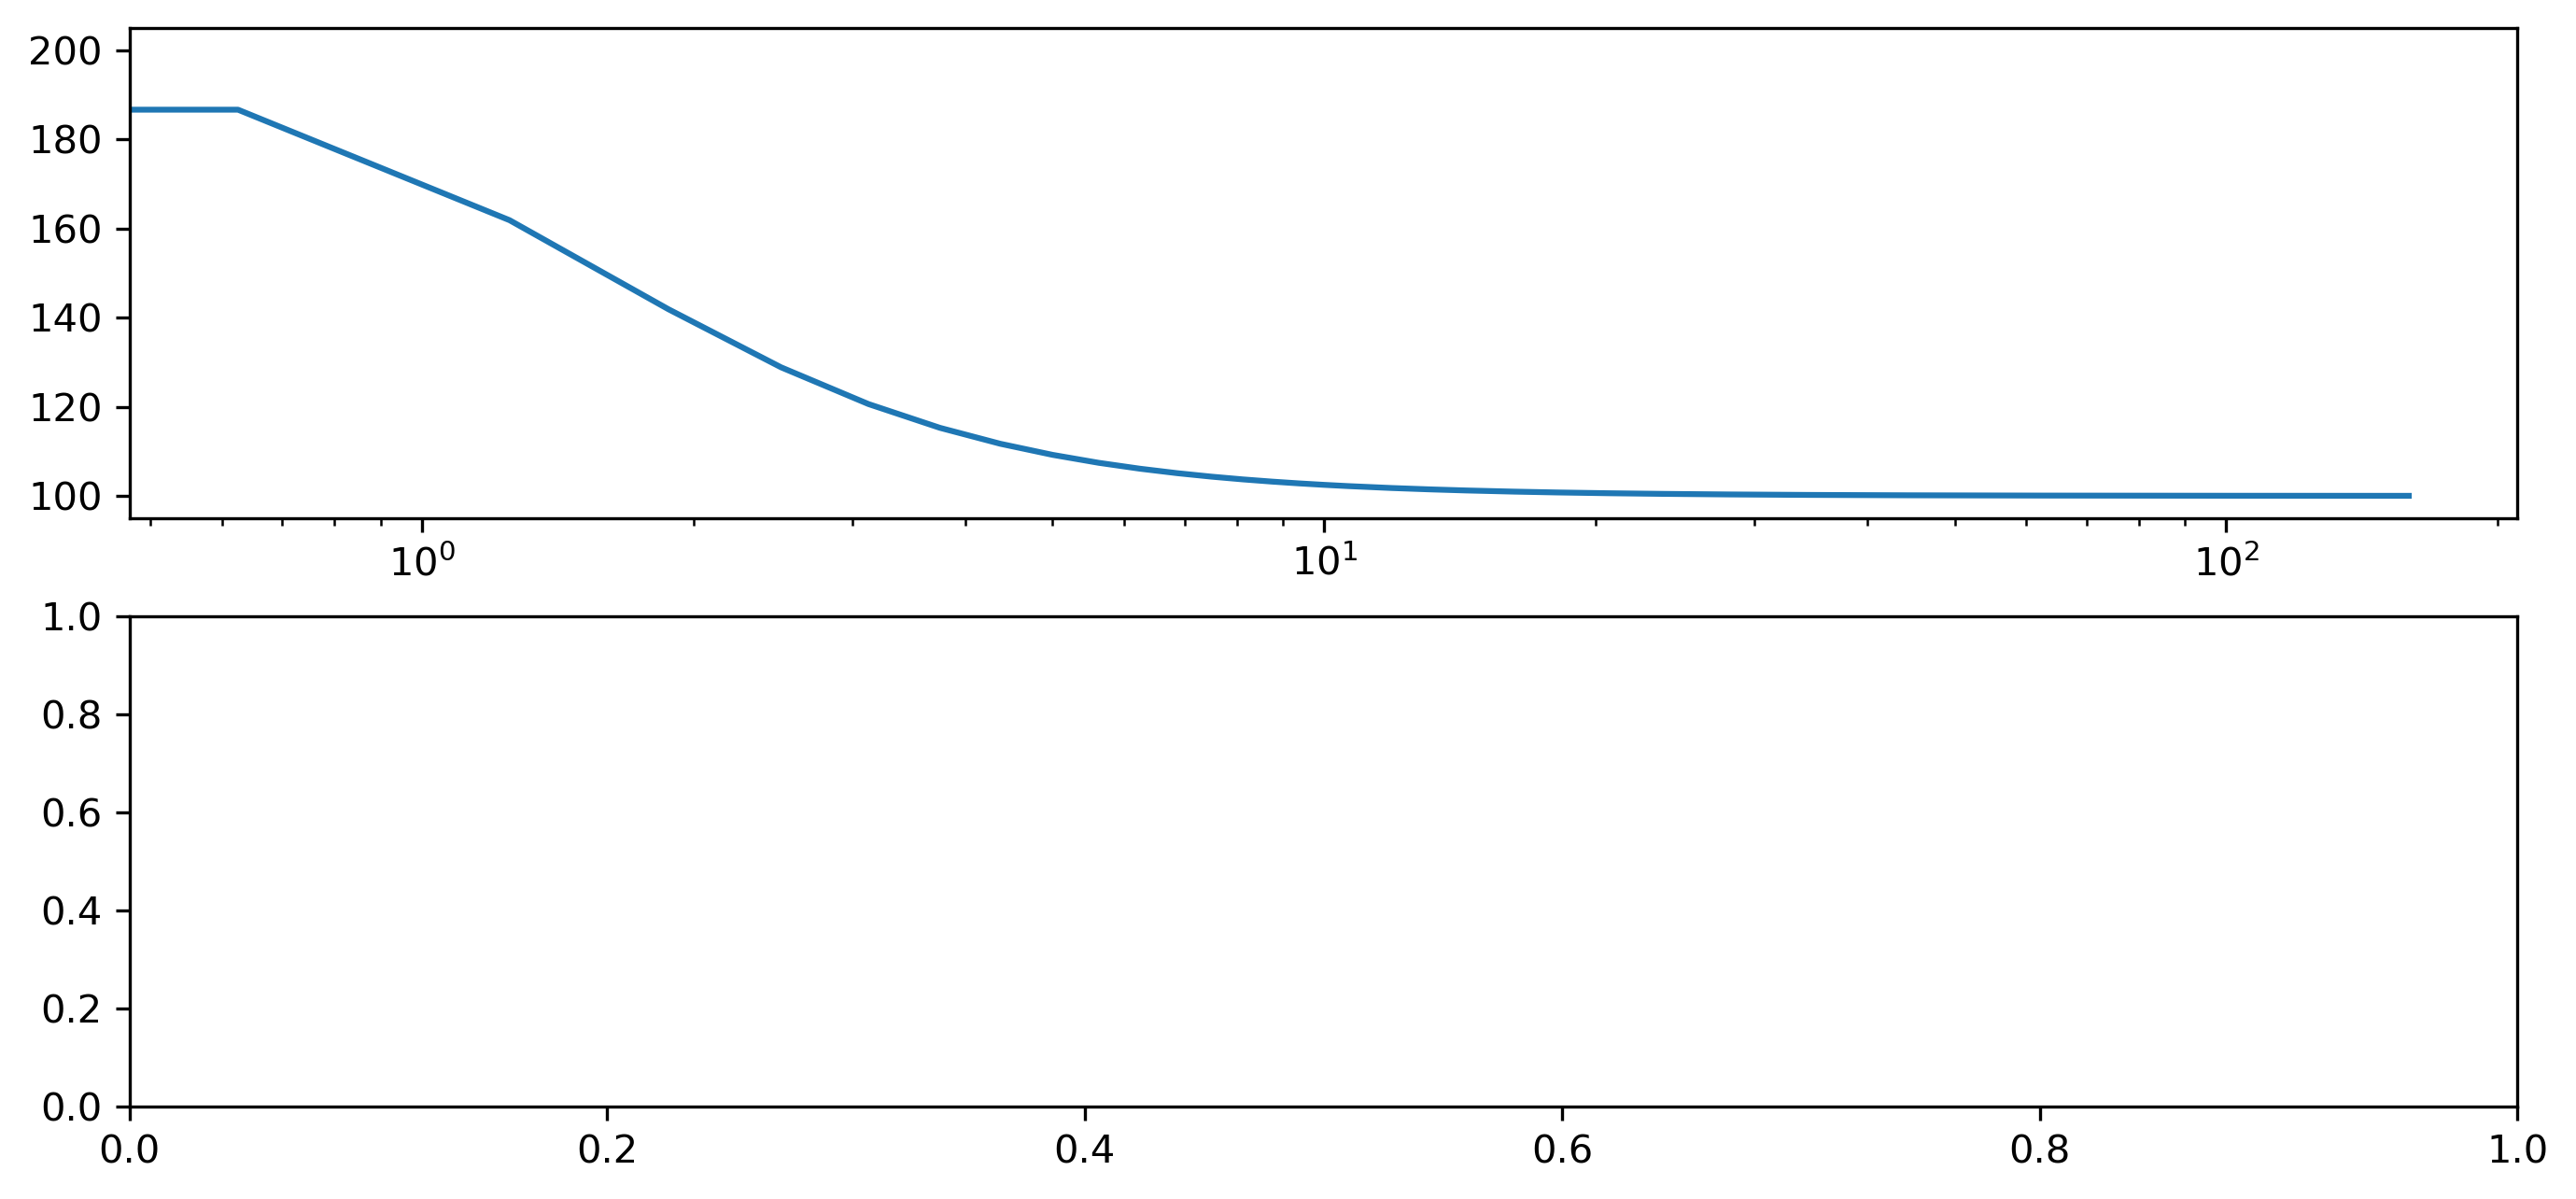

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0].semilogx(freq, fft_f.real, label='Real')

In [39]:

N = 8  # Number of time-domain samples
t = torch.linspace(0, 1, N)

# Create a simple real-valued signal
signal = torch.sin(2 * torch.pi * t)

# Compute FFT
freq_spectrum = torch.fft.fft(signal)

# Apply fftshift (for visualization)
freq_shifted = torch.fft.fftshift(freq_spectrum)

print("Original FFT:", freq_spectrum)
print("Shifted FFT:", freq_shifted)


Original FFT: tensor([ 8.9407e-08+0.0000j,  1.3693e+00-3.3058j, -6.2698e-01+0.6270j,
        -5.0153e-01+0.2077j, -4.8157e-01+0.0000j, -5.0153e-01-0.2077j,
        -6.2698e-01-0.6270j,  1.3693e+00+3.3058j])
Shifted FFT: tensor([-4.8157e-01+0.0000j, -5.0153e-01-0.2077j, -6.2698e-01-0.6270j,
         1.3693e+00+3.3058j,  8.9407e-08+0.0000j,  1.3693e+00-3.3058j,
        -6.2698e-01+0.6270j, -5.0153e-01+0.2077j])


TypeError: max() received an invalid combination of arguments - got (axis=NoneType, out=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out


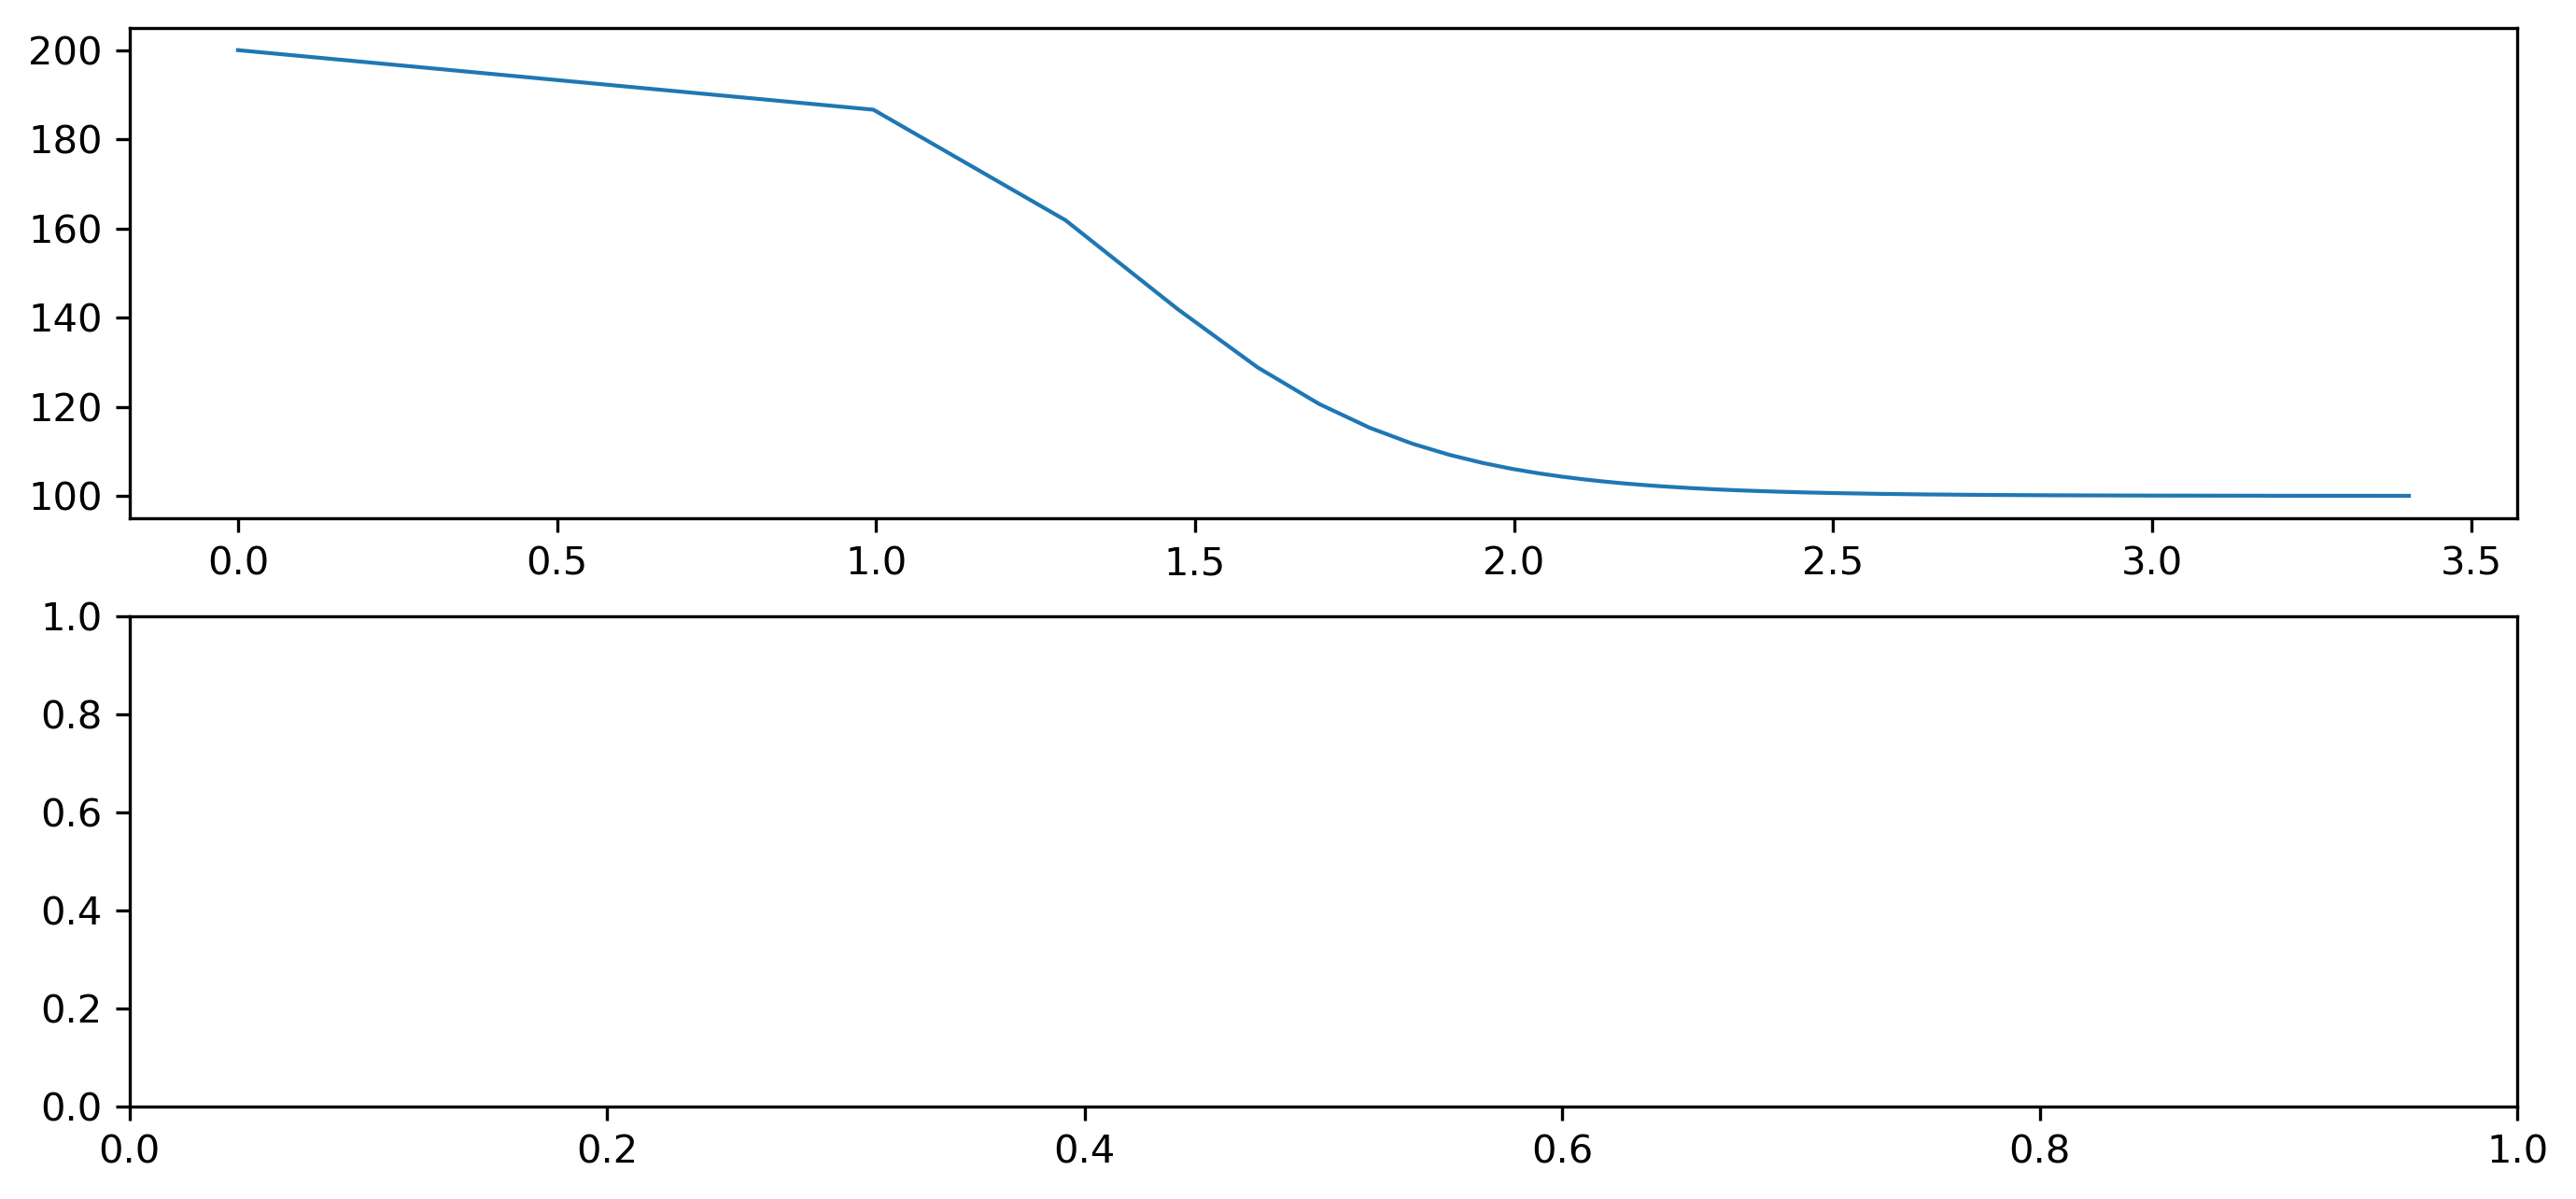

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
ax[0] = PL_pelton.semiplx(x=freq, y=fft_f.real, ax=ax[0], yscale_log=False,
                        label='Real', color="C0")
ax[0] = PL_pelton.semiplx(x=freq, y=fft_f.imag, ax=ax[0], yscale_log=False,
                        label='Imaginary', color="C1")
ax[0] = PL_pelton.semiplx(x=freq, y=np.abs(fft_f), ax=ax[0], yscale_log=False,
                        label='Absolute Value', color="C2")
PL_pelton.pl_axes_x(ax=ax[0])
ax[1] = PL_pelton.semiplx(x=freq, y=np.degrees(np.angle(fft_f)), ax=ax[1], yscale_log=False,
                        label='Phase (degrees)', color="C0")
PL_pelton.pl_axes_x(ax=ax[1])

# Shared x-axis label and vertical line
for a in ax:
    a = PL_pelton.pl_axvline(ax=a, x=1/tau,color="C3",label=r'$1/\tau$')
    #        a = PL_pelton.pl_axvline(ax=a, x=1/tau/2/np.pi,label=r'$1/\tau $')
    a.set_xlabel('Frequency [Hz]')
    a.set_ylabel('Amplitude')
    a.grid(which='both')
    a.legend()
    ax[1].set_ylabel('Phase [Degrees]')


In [6]:
def plot_pelton(freq=None,res0=None, con8=None, eta=0.1, tau=1e-3, c=0.8, ax=None):
    # Assuming `cc` is your complex array, `freq` is the frequency array, and `tau` is defined
    if ax is None:
        fig, ax = plt.subplots(2, 1, figsize=(11, 5),dpi=300)
    if res0 is None and con8 is None:
        raise ValueError('Error: either res0 or con8 must be set')
    elif res0 is not None and con8 is not None:
        raise ValueError('Error: both sigma0 or sigmaInf are set')
    if freq is None:
        nfreq = 2**16
        freqcen = 1 / tau
        freqend = freqcen * nfreq**0.5
        freqstep = freqend / nfreq
        freq = np.arange(0, freqend, freqstep)
    PL_pelton = PsuedoLog(
                logmin=1e-7,
                linScale=0.2,
                logminx=10.**np.floor(np.log10(freq[1])),
                linScalex=0.2)
    IPmodel_f = InducedPolarization(con8=con8, res0=res0, eta=eta, tau=tau, c=c)
    if con8 is None:
        fft_f = IPmodel_f.pelton_res_f(freq, res0, eta, tau, c)
        ax[0].set_title(f''' Pelton model in resistivity form
            res0={res0:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
    if res0 is None:
        fft_f = IPmodel_f.pelton_con_f(freq, con8, eta, tau, c)
        ax[0].set_title(f''' Pelton model in conductivity form
             con8={con8:10.2e}, eta={eta:8.3f}, tau={tau:10.2e}, c={c:8.3f}''')
    ax[0] = PL_pelton.semiplx(x=freq, y=fft_f.real, ax=ax[0], yscale_log=False,
                              label='Real', color="C0")
    ax[0] = PL_pelton.semiplx(x=freq, y=fft_f.imag, ax=ax[0], yscale_log=False,
                              label='Imaginary', color="C1")
    ax[0] = PL_pelton.semiplx(x=freq, y=np.abs(fft_f), ax=ax[0], yscale_log=False,
                              label='Absolute Value', color="C2")
    PL_pelton.pl_axes_x(ax=ax[0])
    ax[1] = PL_pelton.semiplx(x=freq, y=np.degrees(np.angle(fft_f)), ax=ax[1], yscale_log=False,
                              label='Phase (degrees)', color="C0")
    PL_pelton.pl_axes_x(ax=ax[1])

   # Shared x-axis label and vertical line
    for a in ax:
        a = PL_pelton.pl_axvline(ax=a, x=1/tau,color="C3",label=r'$1/\tau$')
#        a = PL_pelton.pl_axvline(ax=a, x=1/tau/2/np.pi,label=r'$1/\tau $')
        a.set_xlabel('Frequency [Hz]')
        a.set_ylabel('Amplitude')
        a.grid(which='both')
        a.legend()
    ax[1].set_ylabel('Phase [Degrees]')
    return ax 

In [7]:
res0min, res0max = 1.0e-3, 1.0e6
log10res0min, log10res0max = np.log10(res0min), np.log10(res0max)
con8min, con8max = 1.0e-6, 1.0e3
log10con8min, log10con8max = np.log10(con8min), np.log10(con8max)
etamin, etamax = 0, 0.99
taumin, taumax = 1.0e-4, 1.0
log10taumin, log10taumax = np.log10(taumin), np.log10(taumax)
cmin, cmax = 0., 1.0
res0_default, eta_default, tau_default, c_default = 200, 0.5,  0.1, 1.
con8_default = 1 / (res0_default * (1 - eta_default))

In [9]:
#  Widget for the main function
def plot_pelton_widget(conductivity_or_resistivity,
         res0=None, con8=None, eta=None, tau=None, c=None):
    # Clear the current output to avoid duplicate figures
    
    # Create the plot
    fig, ax = plt.subplots(2, 1, figsize=(11, 6),dpi=300)


    if conductivity_or_resistivity == "Resistivity":
        ax=plot_pelton(freq=None, res0=res0, eta=eta, tau=tau, c=c, ax=ax)
    else:
        ax=plot_pelton(freq=None, con8=con8, eta=eta, tau=tau, c=c, ax=ax)
    plt.tight_layout()
    return ax

conductivity_or_resistivity = ipywidgets.ToggleButtons(
    options=["Resistivity", "Conductivity"],
    description="Mode:",
    disabled=False,
)
# Define sliders
res0_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(res0min), max=np.log10(res0max), step=0.01,
        value=res0_default, description="Resistivity (res0)")
con8_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(con8min), max=np.log10(con8max), step=0.01,
        value=con8_default, description="Conductivity (con8)")
eta_slider = ipywidgets.FloatSlider(
       min=etamin, max=etamax, step=0.01,
       value=eta_default, description="Chargeability")
tau_slider = ipywidgets.FloatLogSlider(
        base=10, min=np.log10(taumin), max=np.log10(taumax), step=0.01, 
        value=tau_default, description="Time constant(sec)")
c_slider = ipywidgets.FloatSlider(
        min=cmin, max=cmax, step=0.01,
        value=c_default, description="Exponent C")
# Function to update sliders
def update_sliders(mode):
    if mode == "Resistivity":
        return ipywidgets.VBox([res0_slider, eta_slider, tau_slider, c_slider])
    else:
        return ipywidgets.VBox([con8_slider, eta_slider, tau_slider, c_slider])


slider_container = ipywidgets.interactive_output(update_sliders, {'mode': conductivity_or_resistivity})
interactive_plot = ipywidgets.interactive(
    plot_pelton_widget,
    conductivity_or_resistivity=conductivity_or_resistivity,
    res0=res0_slider,
    con8=con8_slider,
    eta=eta_slider,
    tau=tau_slider,
    c=c_slider,
)

# Display all widgets
display(conductivity_or_resistivity, slider_container, interactive_plot)

ToggleButtons(description='Mode:', options=('Resistivity', 'Conductivity'), value='Resistivity')

Output()

interactive(children=(ToggleButtons(description='Mode:', options=('Resistivity', 'Conductivity'), value='Resis…